In [19]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections
import matplotlib.patheffects as PathEffects

import os
from pathlib import Path
from soursop.sssampling import SamplingQuality, hellinger_distance
from soursop.sstrajectory import SSTrajectory, parallel_load_trjs
from soursop.sstools import find_trajectory_files
import seaborn as sns
import mdtraj as md
import pandas as pd
from typing import List, Tuple, Union
from soursop import ssutils
from matplotlib import transforms
from scipy import stats

import itertools

from glob import glob
import matplotlib
import matplotlib.transforms as mtransforms
import matplotlib.font_manager
import pathlib
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'Arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)



# Functions

In [20]:
def quality_plot_with_annotations(qual,
                   dihedral="2D", 
                   increment : int = 5, 
                   x1=None,
                   x2=None, 
                   color=None, 
                   figsize=(7,5), 
                   dpi=400,
                   panel_labels = False, 
                   fontsize = 7, 
                   system="",
                   save_dir=None, 
                   label_position = (-0.0825, 1.10),
                   figname : str = "hellingers",
                   title=None):
        """
        todo
        """
        assert dihedral in ["2D","phi","psi"]
        if panel_labels:
            print(panel_labels)
            fig, axd = plt.subplot_mosaic(panel_labels, 
                                          sharex=False,
                                          figsize=figsize,
                                          dpi=dpi,
                                          facecolor="w",
                                          gridspec_kw={'height_ratios': [2,2]})


        else:
            fig, axd = plt.subplot_mosaic("""BBCC;DDEE""", 
                                      sharex=False,
                                      figsize=figsize,
                                      dpi=dpi,
                                      facecolor="w",
                                      gridspec_kw={'height_ratios': [2,2]})

        selector = {"2D": qual.compute_dihedral_hellingers(),
                    "phi": qual.compute_dihedral_hellingers()[0], 
                    "psi": qual.compute_dihedral_hellingers()[1]}

        all_to_all_selector = {"2D": qual.get_all_to_all_2d_trj_comparison(), 
                             "phi" : qual.get_all_to_all_trj_comparisons()[0], 
                             "psi" : qual.get_all_to_all_trj_comparisons()[1]}

        metric = selector[dihedral]
        print(metric.shape)
        all_to_all = all_to_all_selector[dihedral]

        trj_helicity, ref_helicity = qual.fractional_helicity()

    
        n_res = metric.shape[-1]
        idx = np.arange(1, n_res + 1)
        xticks = np.arange(increment, idx[-1] + 1, increment)
        xticklabels = np.arange(increment, idx[-1] + 1, increment)

        yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
        ytick_labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
        for i, ax in enumerate(axd):
            if i == 0:
                axd[ax].set_yticks(yticks)
                axd[ax].set_yticklabels(ytick_labels, fontsize=fontsize)
                axd[ax].set_ylim([0, 1])
                axd[ax].set_ylabel("Hellinger's Distance", fontsize=fontsize)
                axd[ax].set_title(
                    "Trajectory-to-Excluded-Volume Comparison", fontsize=fontsize
                )
                axd[ax].set_xticks(xticks)
                axd[ax].set_xticklabels(xticklabels, fontsize=fontsize)
                axd[ax].set_xlim([0, idx[-1]+1])

                # plot all red marks
                axd[ax].plot(idx, metric.transpose(), '.r', ms=4, alpha=0.3, mew=0)

                # plot mean
                axd[ax].plot(idx, np.mean(metric, axis=0), 'sk-', ms=2, alpha=1, mew=0, linewidth=0.5)

            elif i == 1:
                axd[ax].set_yticks(yticks)
                axd[ax].set_yticklabels(ytick_labels, fontsize=fontsize)
                axd[ax].set_ylim([0, 1])
                axd[ax].set_ylabel("Hellinger's Distance", fontsize=fontsize)

                axd[ax].set_title("All-to-All Trajectory Comparison", fontsize=fontsize)

                axd[ax].set_xticks(xticks)
                axd[ax].set_xticklabels(xticklabels, fontsize=fontsize)
                axd[ax].set_xlim([0, idx[-1]+1])

                axd[ax].plot(idx, all_to_all.transpose(), '.r', ms=4, alpha=0.3, mew=0)                

                # plot mean
                axd[ax].plot(idx, np.mean(all_to_all, axis=0), 'sk-', ms=2, alpha=1, mew=0, linewidth=0.5)

            elif i == 2:
                # axd[ax].spines.right.set_visible(False)
                # axd[ax].spines.top.set_visible(False)
                axd[ax].set_yticks(yticks)
                axd[ax].set_yticklabels(ytick_labels, fontsize=fontsize)
                axd[ax].set_ylim([0, 1])
                axd[ax].set_ylabel("Hellinger's Distance\nmax - min", fontsize=fontsize)
                axd[ax].set_xlabel("Residue", fontsize=fontsize)
                axd[ax].set_title(
                    "Trajectory-to-Excluded-Volume Comparison", fontsize=fontsize
                )
                
                axd[ax].set_xticks(xticks)
                axd[ax].set_xticklabels(xticklabels, fontsize=fontsize)
                axd[ax].set_xlim([0, idx[-1]+1])
                
                max_minus_min = np.ptp(metric, axis=0)
                axd[ax].bar(idx, max_minus_min, width=0.8, color='k')

            elif i==3:
                # need to check if we have caps or not as that changes # psi/phi
                caps = qual.trajs[0].proteinTrajectoryList[0].ncap & qual.trajs[0].proteinTrajectoryList[0].ccap 
                
                if not caps:
                    # idx = np.arange(1, n_res + 1)
                    idx = np.arange(1, n_res+2)
                
                axd[ax].set_yticks(yticks)
                axd[ax].set_yticklabels(ytick_labels, fontsize=fontsize)
                axd[ax].set_ylim([0, 1])
                axd[ax].set_ylabel("Fractional Helicity", fontsize=fontsize)
                axd[ax].set_xlabel("Residue", fontsize=fontsize)
                axd[ax].set_title("Secondary Structure Propensity", fontsize=fontsize)

                axd[ax].set_xticks(xticks,)
                axd[ax].set_xticklabels(xticklabels, fontsize=fontsize)
                axd[ax].set_xlim([0, idx[-1]+1])

                # plot red
                axd[ax].plot(idx, trj_helicity.transpose(), '.r', ms=4, alpha=0.3, mew=0)
                
                # print("index shape: ",idx.shape)
                # print("trj_helicity shape: ", trj_helicity.shape)
                
                

                # plot line avg helicity
                axd[ax].plot(idx, np.mean(trj_helicity, axis=0), 'sk-', ms=2, alpha=1, mew=0, linewidth=0.5)

        for ax in axd:
            trans = transforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
            axd[ax].text(-0.0825, 1.10, ax, transform=axd[ax].transAxes+trans,
                         fontsize=fontsize, fontweight='bold', va='top', ha='right')


        if (x1 and x2) != None:
            for ax in axd:
                axd[ax].axvspan(x1,x2, alpha=0.5, facecolor=color,label="Region Fixed")
    #             axd[ax].legend(frameon=False)
        elif (x1 is not None and x2 is None):
            for ax in axd:
                axd[ax].axvline(x1, alpha=1, linewidth=0.5,linestyle="--",color=color,label="Region Diviser")
    #             axd[ax].legend(frameon=False)
        else:
            pass

        if title:
            plt.suptitle(f"Bin width = {round(np.rad2deg(qual.bwidth),0)} (degrees)")
            
        plt.tight_layout()
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            # outpath = os.path.join(save_dir, f"{system}_{dihedral}_hellingers.pdf")
            outpath = os.path.join(save_dir, f"{system}_{dihedral}_{figname}.pdf")
            fig.savefig(f"{outpath}", dpi=dpi)

    
        return fig, axd


In [21]:
fig_path = Path("figures").resolve()

# Fig S2

In [39]:
polyGV_traj_paths, polyGV_top_paths,  = find_trajectory_files("simulations/polyGV-PGSK/full/",20)

polyGV_ev_traj_paths,polyGV_ev_top_paths = find_trajectory_files("simulations/polyGV-PGSK/ev/",20)

polyGV_qual = SamplingQuality(polyGV_traj_paths, 
                              polyGV_ev_traj_paths,
                              top_file=polyGV_top_paths[0],
                              ref_top=polyGV_ev_top_paths[0],
                              method="2D angle distributions",
                              truncate=True)

Successfully truncated.
                The shortest trajectory is: 3200 frames.                All trajectories truncated to 3200


## calculate rgs

In [40]:
polyGV_rgs = []
for i,trj in enumerate(polyGV_qual.trajs):
    polyGV_rgs.append(trj.proteinTrajectoryList[0].get_radius_of_gyration())
polyGV_rgs = np.array(polyGV_rgs)

Running Barletts Test of equal variances

Variances are not significantly different among replicates.

Running ANOVA to compare means

Means are not significantly different among replicates.


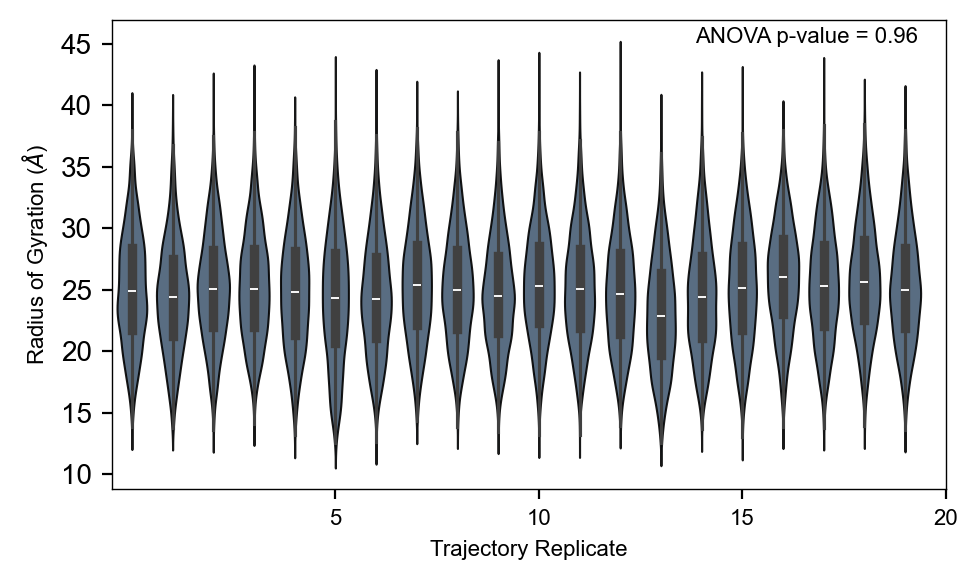

In [41]:
polyGV_df = pd.DataFrame(polyGV_rgs)

increment = 5
n_reps = polyGV_rgs.shape[0]
fontsize=8

idx = np.arange(1, n_reps+1)
xticks = np.arange(increment, idx[-1]+1, increment)
xticklabels = np.arange(increment, idx[-1]+1, increment)


fig, ax = plt.subplots(figsize=(5,3),facecolor="w")

ax.set_xlabel("Trajectory Replicate",fontsize=fontsize)
ax.set_ylabel(r"Radius of Gyration ($\AA$)",fontsize=fontsize)

# Perform Bartlett's test for equality of variances
statistic, p_value = stats.bartlett(*[col for col in polyGV_df.T.values])

# Check the p-value to determine if variances are equal
print("Running Barletts Test of equal variances")
print()
if p_value > 0.05:
    print("Variances are not significantly different among replicates.")
else:
    print("At least one replicate has a significantly different variance.")


# Perform ANOVA test
f_statistic, anova_p_value = stats.f_oneway(*[col for col in polyGV_df.T.values])

# Add p-value annotation to the plot
ax.annotate(f'ANOVA p-value = {anova_p_value:.2f}', xy=(0.7, 0.95), xycoords='axes fraction', fontsize=fontsize)

print()
print("Running ANOVA to compare means")
print()
# Check the p-value to determine if means are equal
if anova_p_value > 0.05:
    print("Means are not significantly different among replicates.")
else:
    print("At least one of the replicates has a significantly different mean.")

#########    #
parts = sns.violinplot(polyGV_df.T,
                       # points=50,
                       color="#3F5D7D",
#                        inner=None,
#                        width=0.4,
#                        saturation=1,
                       linewidth=0.75)
#########    #
violins = [c for i, c in enumerate(ax.collections)]
[v.set_edgecolor("k") for v in violins]
[v.set_alpha(0.9) for v in violins]

ax.set_xticks(xticks,labels=xticks, fontsize=fontsize)
# ax.set_xticklabels(xticklabels)


# Add a legend
# ax.legend(loc='upper left',frameon=False,fontsize=fontsize)



plt.tight_layout()
os.makedirs(f"{fig_path}/si_figures/pdfs/",exist_ok=True)
plt.savefig(f"{fig_path}/si_figures/pdfs/polyGV_rg_anova.pdf",dpi=400)

plt.show()

## Fig S3 - GCN4 temperature dependence

In [42]:
gcn4_ev_traj, gcn4_ev_top = find_trajectory_files("simulations/GCN4/ev_270K/",15)

In [43]:
gcn4_quals = {}
directories = glob("simulations/GCN4/*K")
directories = sorted([Path(temp).parts[-1] for temp in directories if temp not in ["ev_270K","ev_340K"]])
for temperature in tqdm(directories):
    if temperature in ["150K","200K","250K","300K","310K","320K","330K","340K","350K","400K"]:
        gcn4_traj, gcn4_top = find_trajectory_files(f"simulations/GCN4/{temperature}/coil_start",15)
        gcn4_qual = SamplingQuality(gcn4_traj,gcn4_ev_traj, top_file=gcn4_top[0],
                                        ref_top=gcn4_ev_top[0],method="2D angle distributions")
        gcn4_quals[temperature] = gcn4_qual



00%|████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:58<00:00,  7.41s/it]

In [44]:
trj_frac_helicity,ref_frac_helicity, hellingers = [],[],[]
for temperature in gcn4_quals:
    hellingers.append(gcn4_quals[temperature].hellingers_distances())
    trj_frac_helicity.append(gcn4_quals[temperature].fractional_helicity()[0])
    ref_frac_helicity.append(gcn4_quals[temperature].fractional_helicity()[1])
hellingers = np.array(hellingers)
trj_frac_helicity= np.array(trj_frac_helicity)
ref_frac_helicity= np.array(ref_frac_helicity)

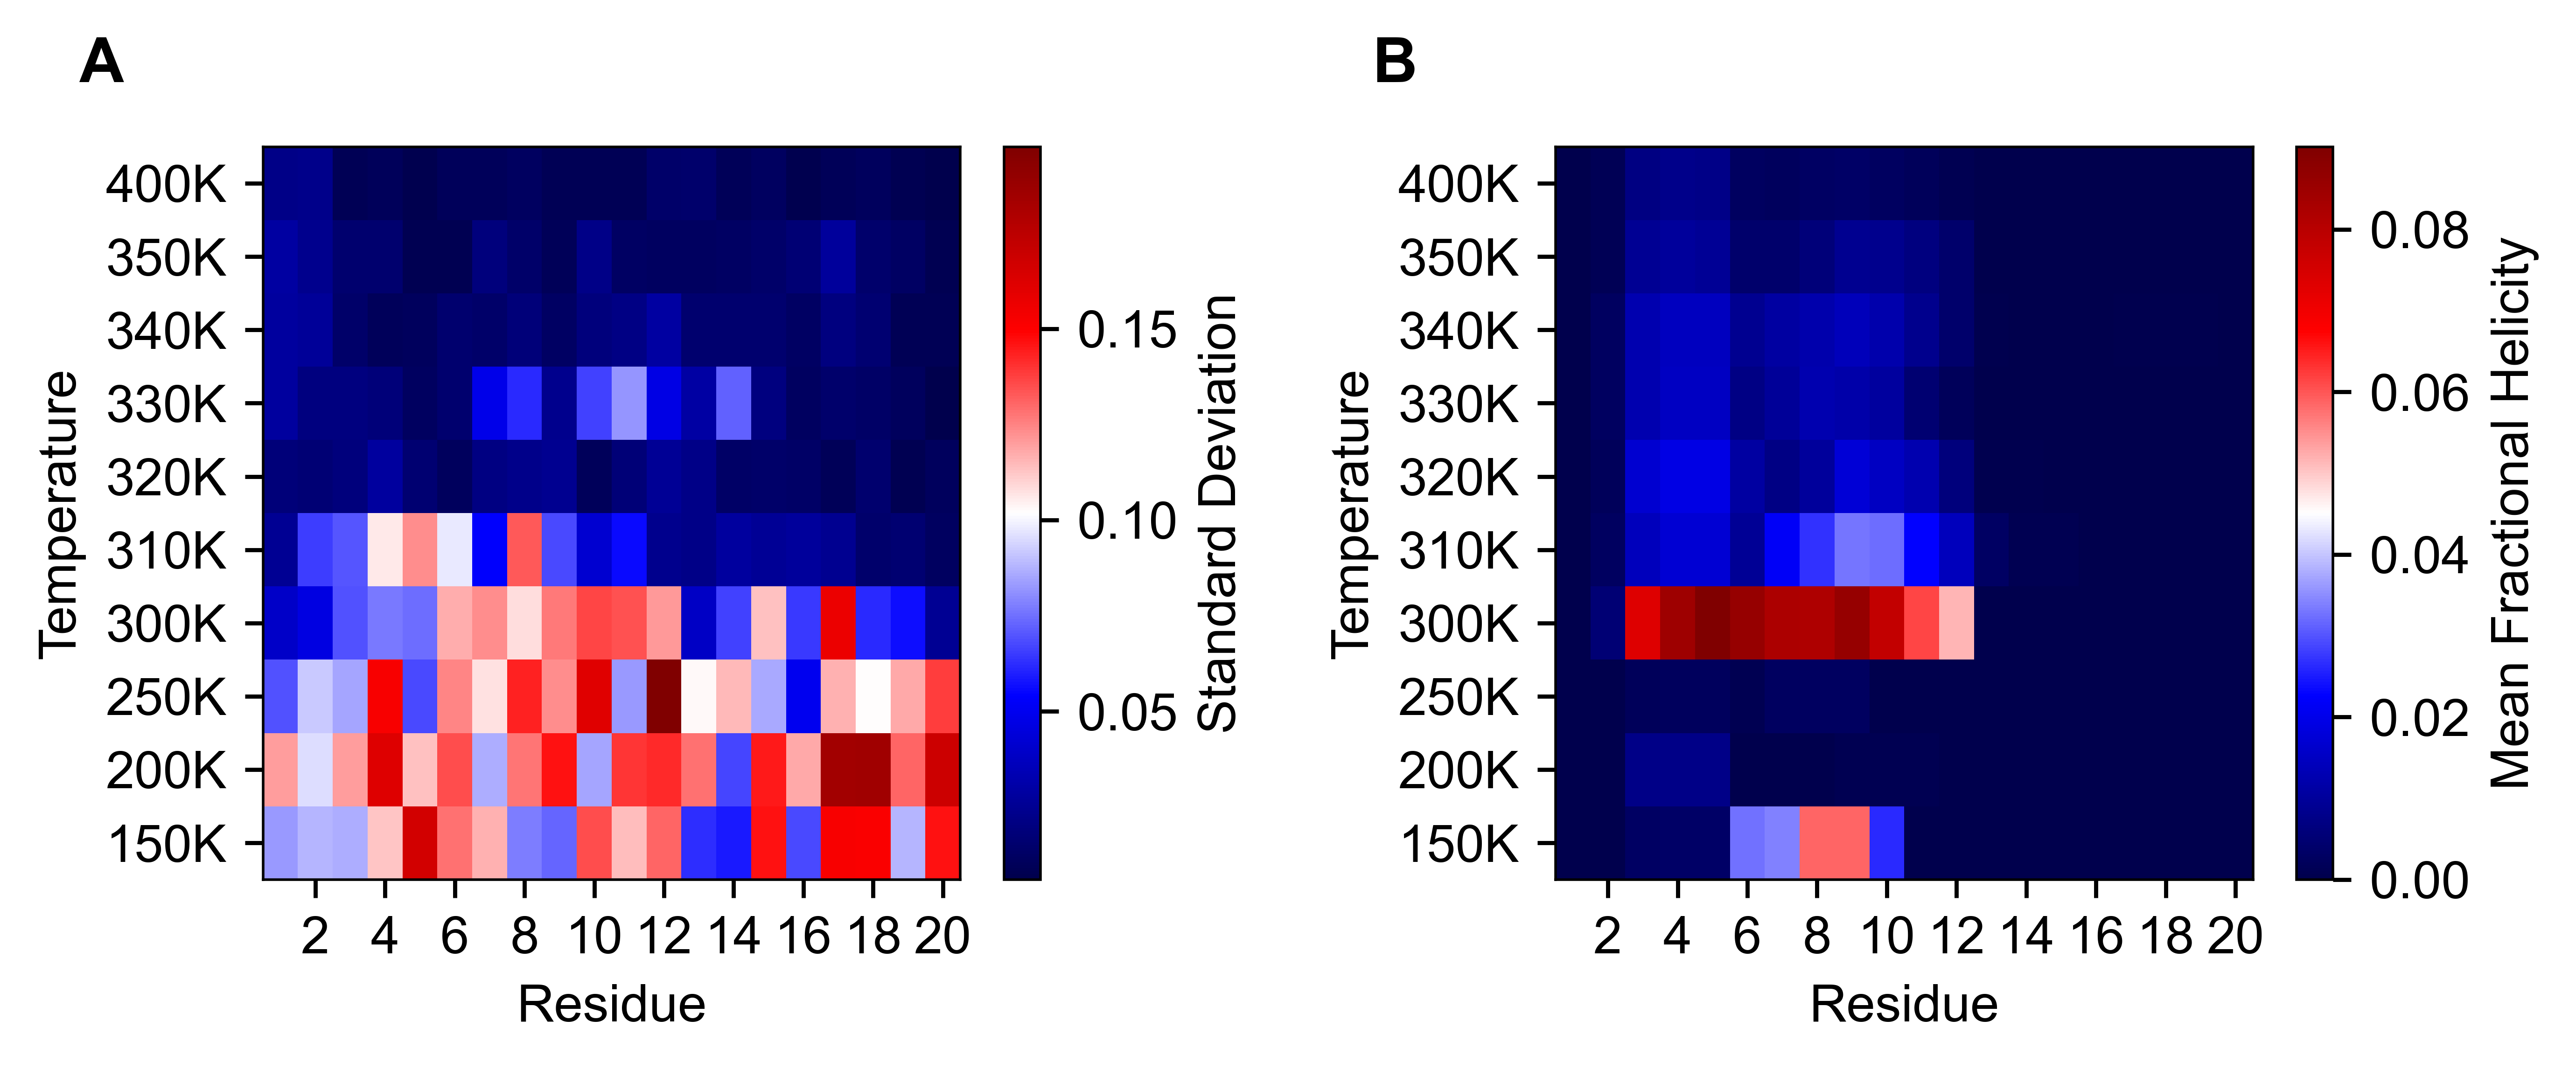

In [45]:
hellingers_std = np.std(hellingers,axis=1)
mean_frac_helicity = np.mean(trj_frac_helicity,axis=1)

fontsize=10

fig, axes = plt.subplots(1,2,figsize=(7,3),facecolor="w",dpi=400)
x_ticks = np.arange(1,hellingers_std.shape[1],2) +0.5
x_ticklabels = np.arange(2,hellingers_std.shape[1]+2, 2)
y_ticks = .5+np.arange(0,10)
y_ticklabels = ["150K","200K","250K","300K","310K","320K","330K","340K","350K","400K"]


axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_ticklabels,fontsize=fontsize)
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels(y_ticklabels,fontsize=fontsize)
axes[0].set_xlabel("Residue")
axes[0].set_ylabel("Temperature")
mesh = axes[0].pcolormesh(hellingers_std,cmap="seismic")
fig.colorbar(mesh,label="Standard Deviation",ax=axes[0])

axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_ticklabels,fontsize=fontsize)
axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels(y_ticklabels,fontsize=fontsize)
axes[1].set_xlabel("Residue")
axes[1].set_ylabel("Temperature")
mesh = axes[1].pcolormesh(mean_frac_helicity,cmap="seismic")
fig.colorbar(mesh,label="Mean Fractional Helicity",ax=axes[1])



for i,ax in enumerate(axes):
    if i ==0:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.05, 1.10, "A", transform=ax.transAxes+trans,
                fontsize=12, fontweight='bold', va='top', ha='right')
    else:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.05, 1.10, "B", transform=ax.transAxes+trans,
                fontsize=12, fontweight='bold', va='top', ha='right')
plt.tight_layout()

plt.savefig(f"{fig_path}/si_figures/pdfs/GCN4_2D_hellingers_std_vs_temp.pdf",dpi=400)
plt.show()

## Fig S4 - Binning

Note - inherent to any discretization

In [ ]:
def compare_axes_across_bin_widths(bin_widths,fig_path):
    """
    Generate comparison plots for the first and second axes (`ax[0]` and `ax[1]`)
    across multiple bin widths.

    Parameters:
        quality_plot_func: The function to generate individual subplots.
        qual: The quality object containing the data for plotting.
        bin_widths: List of bin widths to iterate over.
        kwargs: Additional keyword arguments to pass to the quality_plot_func.

    Returns:
        fig1, fig2: Figures for the comparisons of `ax[0]` and `ax[1]`.
    """
    # Store the data for ax[0] and ax[1] across bin widths
    ax0_data = []
    ax1_data = []
    traj_paths, top_paths = find_trajectory_files("simulations/fs", num_replicates=10)
    ev_traj_paths, ev_top_paths = find_trajectory_files("simulations/fs-ev/", num_replicates=10)

    for bwidth in bin_widths:
        # Generate the plots and get the axes
        fs_qual = SamplingQuality(
            traj_paths, 
            ev_traj_paths, 
            top_file=top_paths[0], 
            ref_top=ev_top_paths[0], 
            method="2D angle distributions",
            bwidth=np.deg2rad(bwidth)
        )
        
        fig, axd = quality_plot_with_annotations(
            fs_qual,
            figsize=(7, 6),
            increment=2,
            panel_labels="""AABB;CCDD""",
            fontsize=10,
            dihedral="2D",
            system="fs_qual",
            save_dir=f"{fig_path}/si_figures/pdfs",
            figname=f"{round(np.rad2deg(fs_qual.bwidth), 2)}",
            title=True
        )
        # Extract data for ax[0] and ax[1]
        ax0_lines = axd['A'].lines  # Assuming axd['A'] corresponds to ax[0]
        ax1_lines = axd['B'].lines  # Assuming axd['B'] corresponds to ax[1]

        # Extract the mean line data (assuming it's the second line)
        ax0_data.append(ax0_lines[1].get_ydata())
        ax1_data.append(ax1_lines[1].get_ydata())

        # plt.close(fig)  # Close the individual plot to save memory

    # Prepare residue indices
    residues = np.arange(1, len(ax0_data[0]) + 1)

    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ytick_labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    
    
    # Create comparison plots
    fig1, ax1 = plt.subplots(figsize=(7, 6))
    for i, data in enumerate(ax0_data):
        ax1.plot(residues, data, label=f'Bin width: {bin_widths[i]:.1f}°')
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ytick_labels, fontsize=10)
    ax1.set_ylim([0, 1])
    ax1.set_title("Trajectory-to-Excluded-Volume Mean Comparison Across Bin Widths")
    ax1.set_xlabel("Residue")
    ax1.set_ylabel("Hellinger's Distance")
    plt.savefig(f"{fig_path}/si_figures/fs_traj_to_excluded_volume_mean_bin_width_comparison.pdf",dpi=300)
    ax1.legend()

    fig2, ax2 = plt.subplots(figsize=(7, 6))
    for i, data in enumerate(ax1_data):
        ax2.plot(residues, data, label=f'Bin width: {bin_widths[i]:.1f}°')
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(ytick_labels, fontsize=10)
    ax2.set_ylim([0, 1])
    ax2.set_title("All-to-All Trajectory Mean Comparison Across Bin Widths")
    ax2.set_xlabel("Residue")
    ax2.set_ylabel("Hellinger's Distance")
    plt.savefig(f"{fig_path}/si_figures/fs_all_to_all_traj_mean_bin_width_comparison.pdf",dpi=300)
    ax2.legend()

    return fig1, fig2


# Define bin widths and the figure save path
bin_widths = [5, 15, 30, 45, 60, 120]

# Call the function
compare_axes_across_bin_widths(bin_widths, fig_path)


In [4]:
synth_workdir = "/work/j.lotthammer/projects/penguin_sims/coil_start"

In [202]:
synth_traj_paths,synth_top_paths = find_trajectory_files(synth_workdir,num_replicates=10)

In [206]:
# synth_qual = SamplingQuality(synth_traj_paths,synth_top_paths)

synth_qual = SamplingQuality(synth_traj_paths,
                               top_file=synth_top_paths[0],
                               method="2D angle distributions",
                               )

  0%|                                                                                           | 0/6 [00:00<?, ?it/s]

AABB;CCDD
(10, 40)
index shape:  (40,)
trj_helicity shape:  (10, 40)


 17%|█████████████▋                                                                    | 1/6 [02:40<13:21, 160.28s/it]

AABB;CCDD
(10, 40)
index shape:  (40,)
trj_helicity shape:  (10, 40)


 33%|███████████████████████████▎                                                      | 2/6 [05:18<10:37, 159.28s/it]

AABB;CCDD
(10, 40)
index shape:  (40,)
trj_helicity shape:  (10, 40)


 50%|█████████████████████████████████████████                                         | 3/6 [07:58<07:57, 159.30s/it]

AABB;CCDD
(10, 40)
index shape:  (40,)
trj_helicity shape:  (10, 40)


 67%|██████████████████████████████████████████████████████▋                           | 4/6 [10:35<05:17, 158.65s/it]

AABB;CCDD
(10, 40)
index shape:  (40,)
trj_helicity shape:  (10, 40)


 83%|████████████████████████████████████████████████████████████████████▎             | 5/6 [13:13<02:38, 158.19s/it]

AABB;CCDD
(10, 40)
index shape:  (40,)
trj_helicity shape:  (10, 40)



00%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [15:44<00:00, 157.44s/it]

(<Figure size 700x500 with 1 Axes>, <Figure size 700x500 with 1 Axes>)

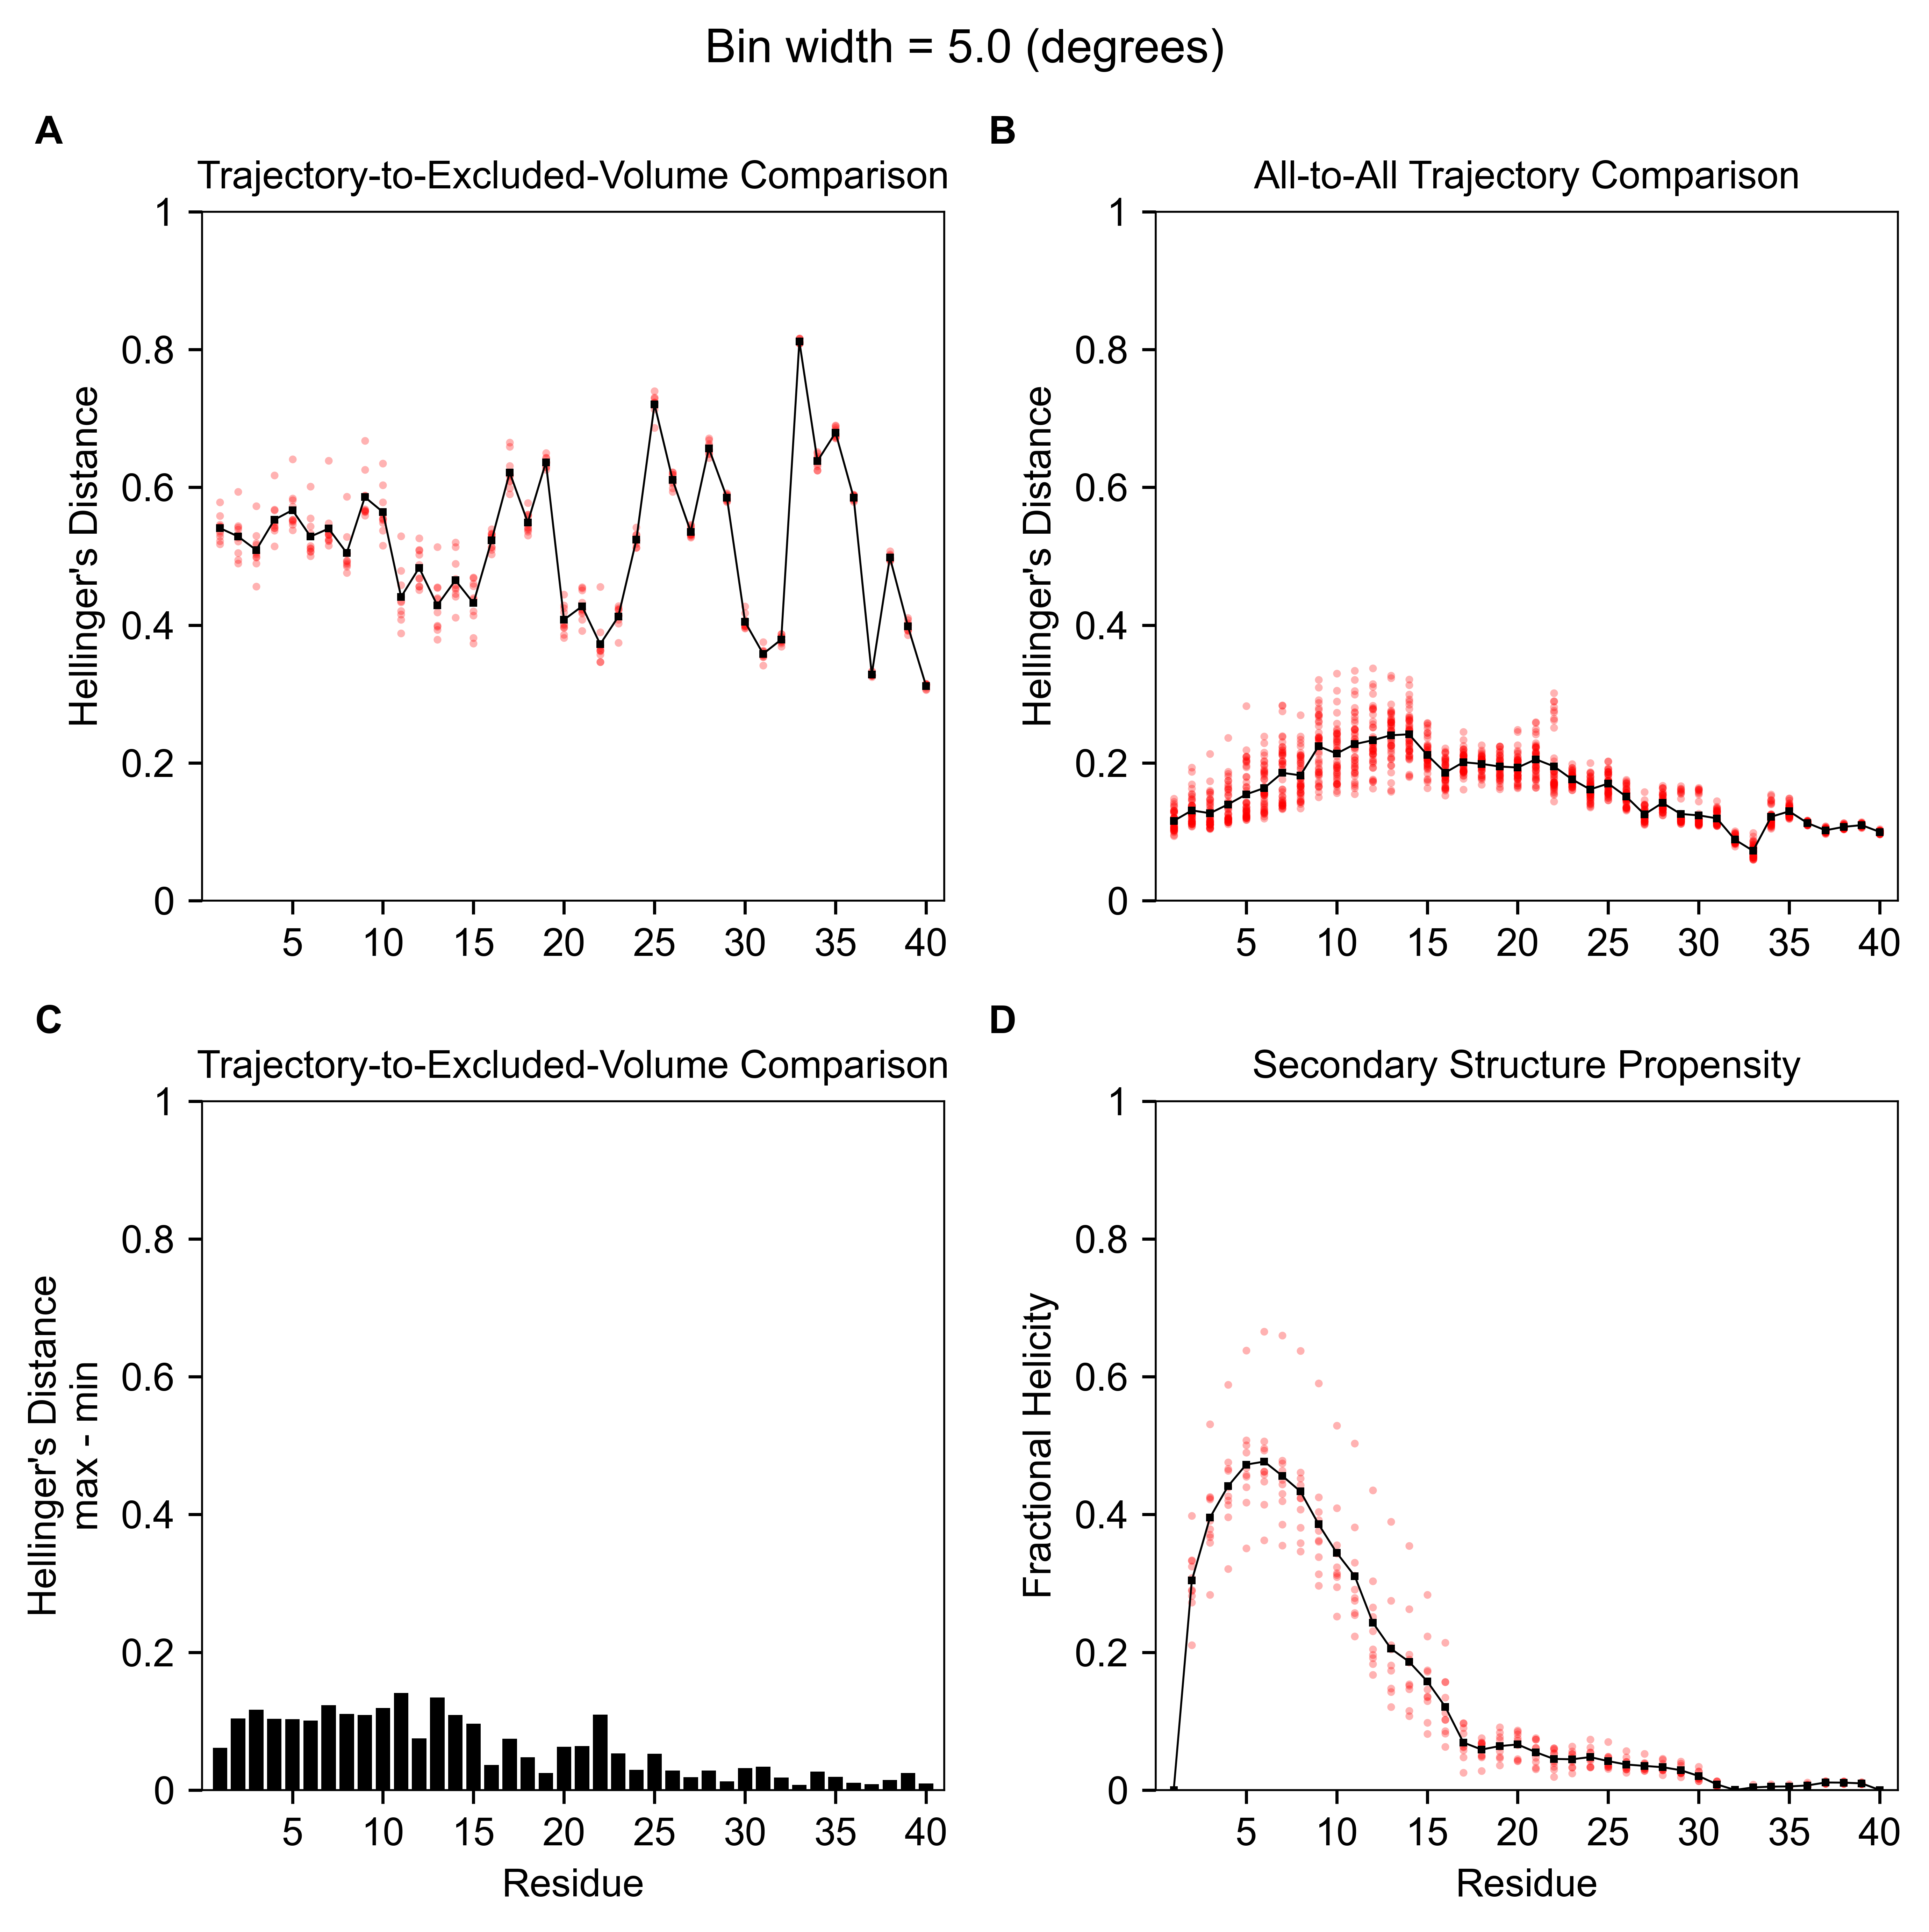

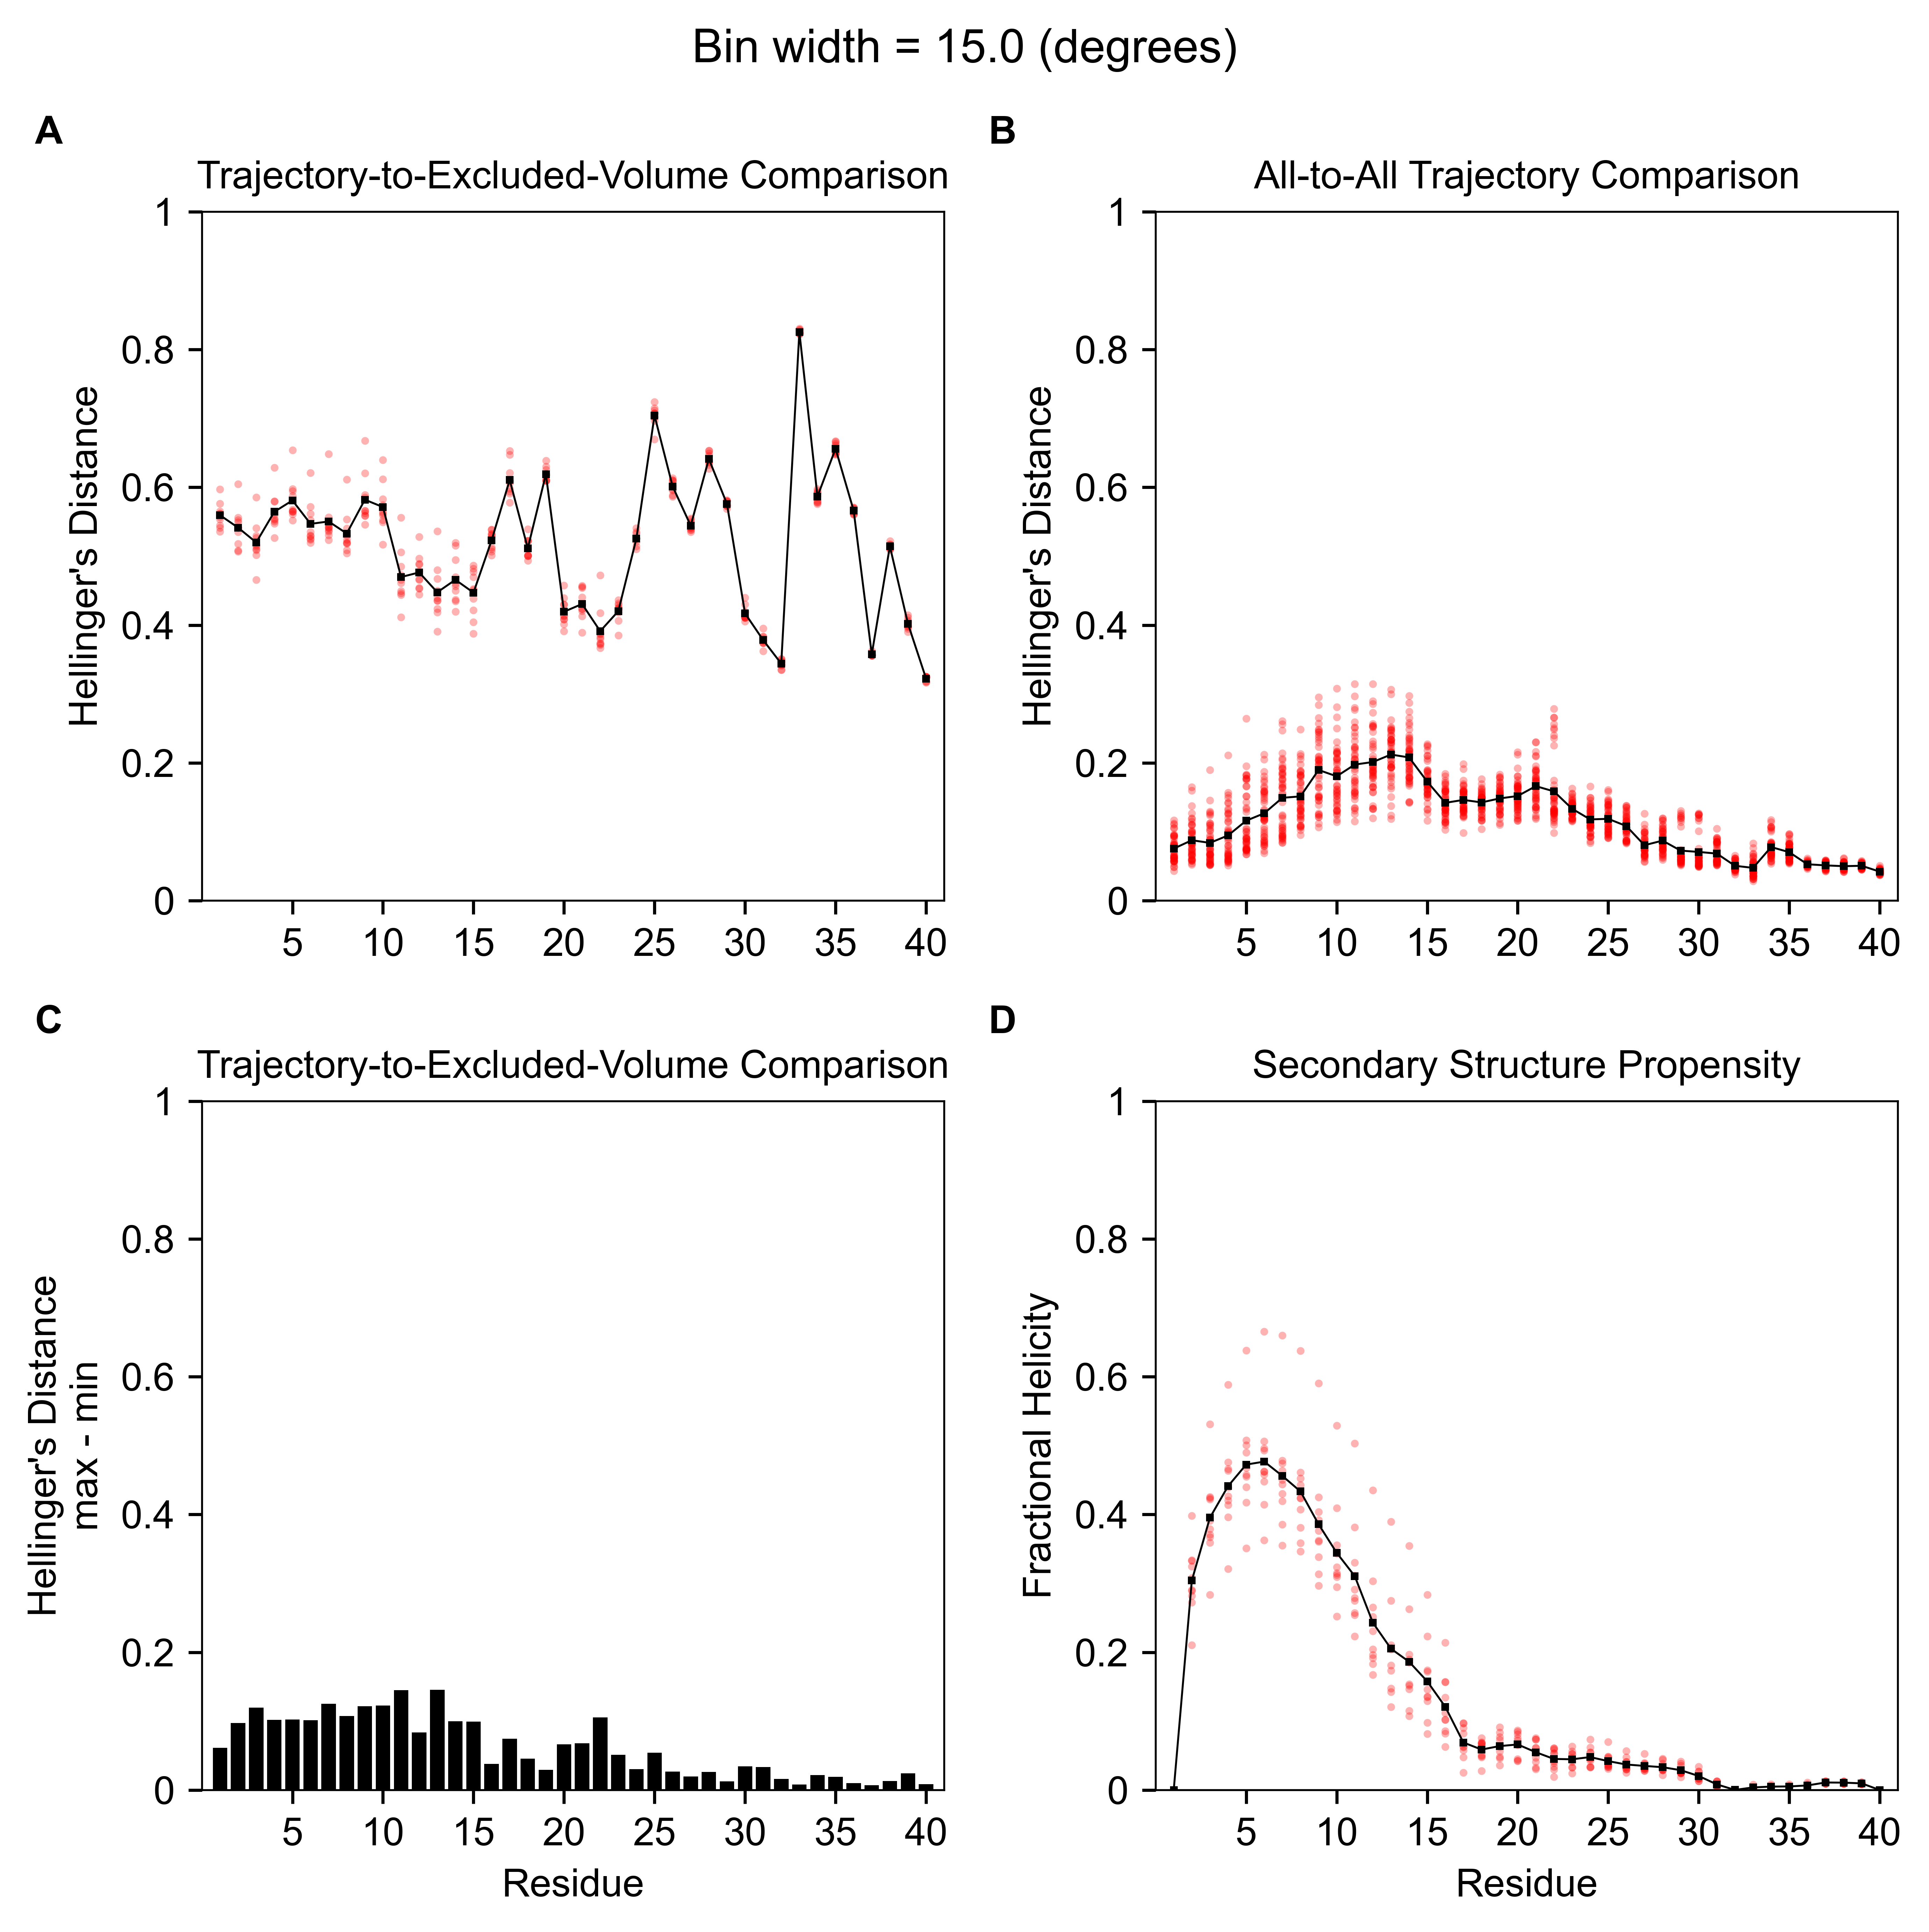

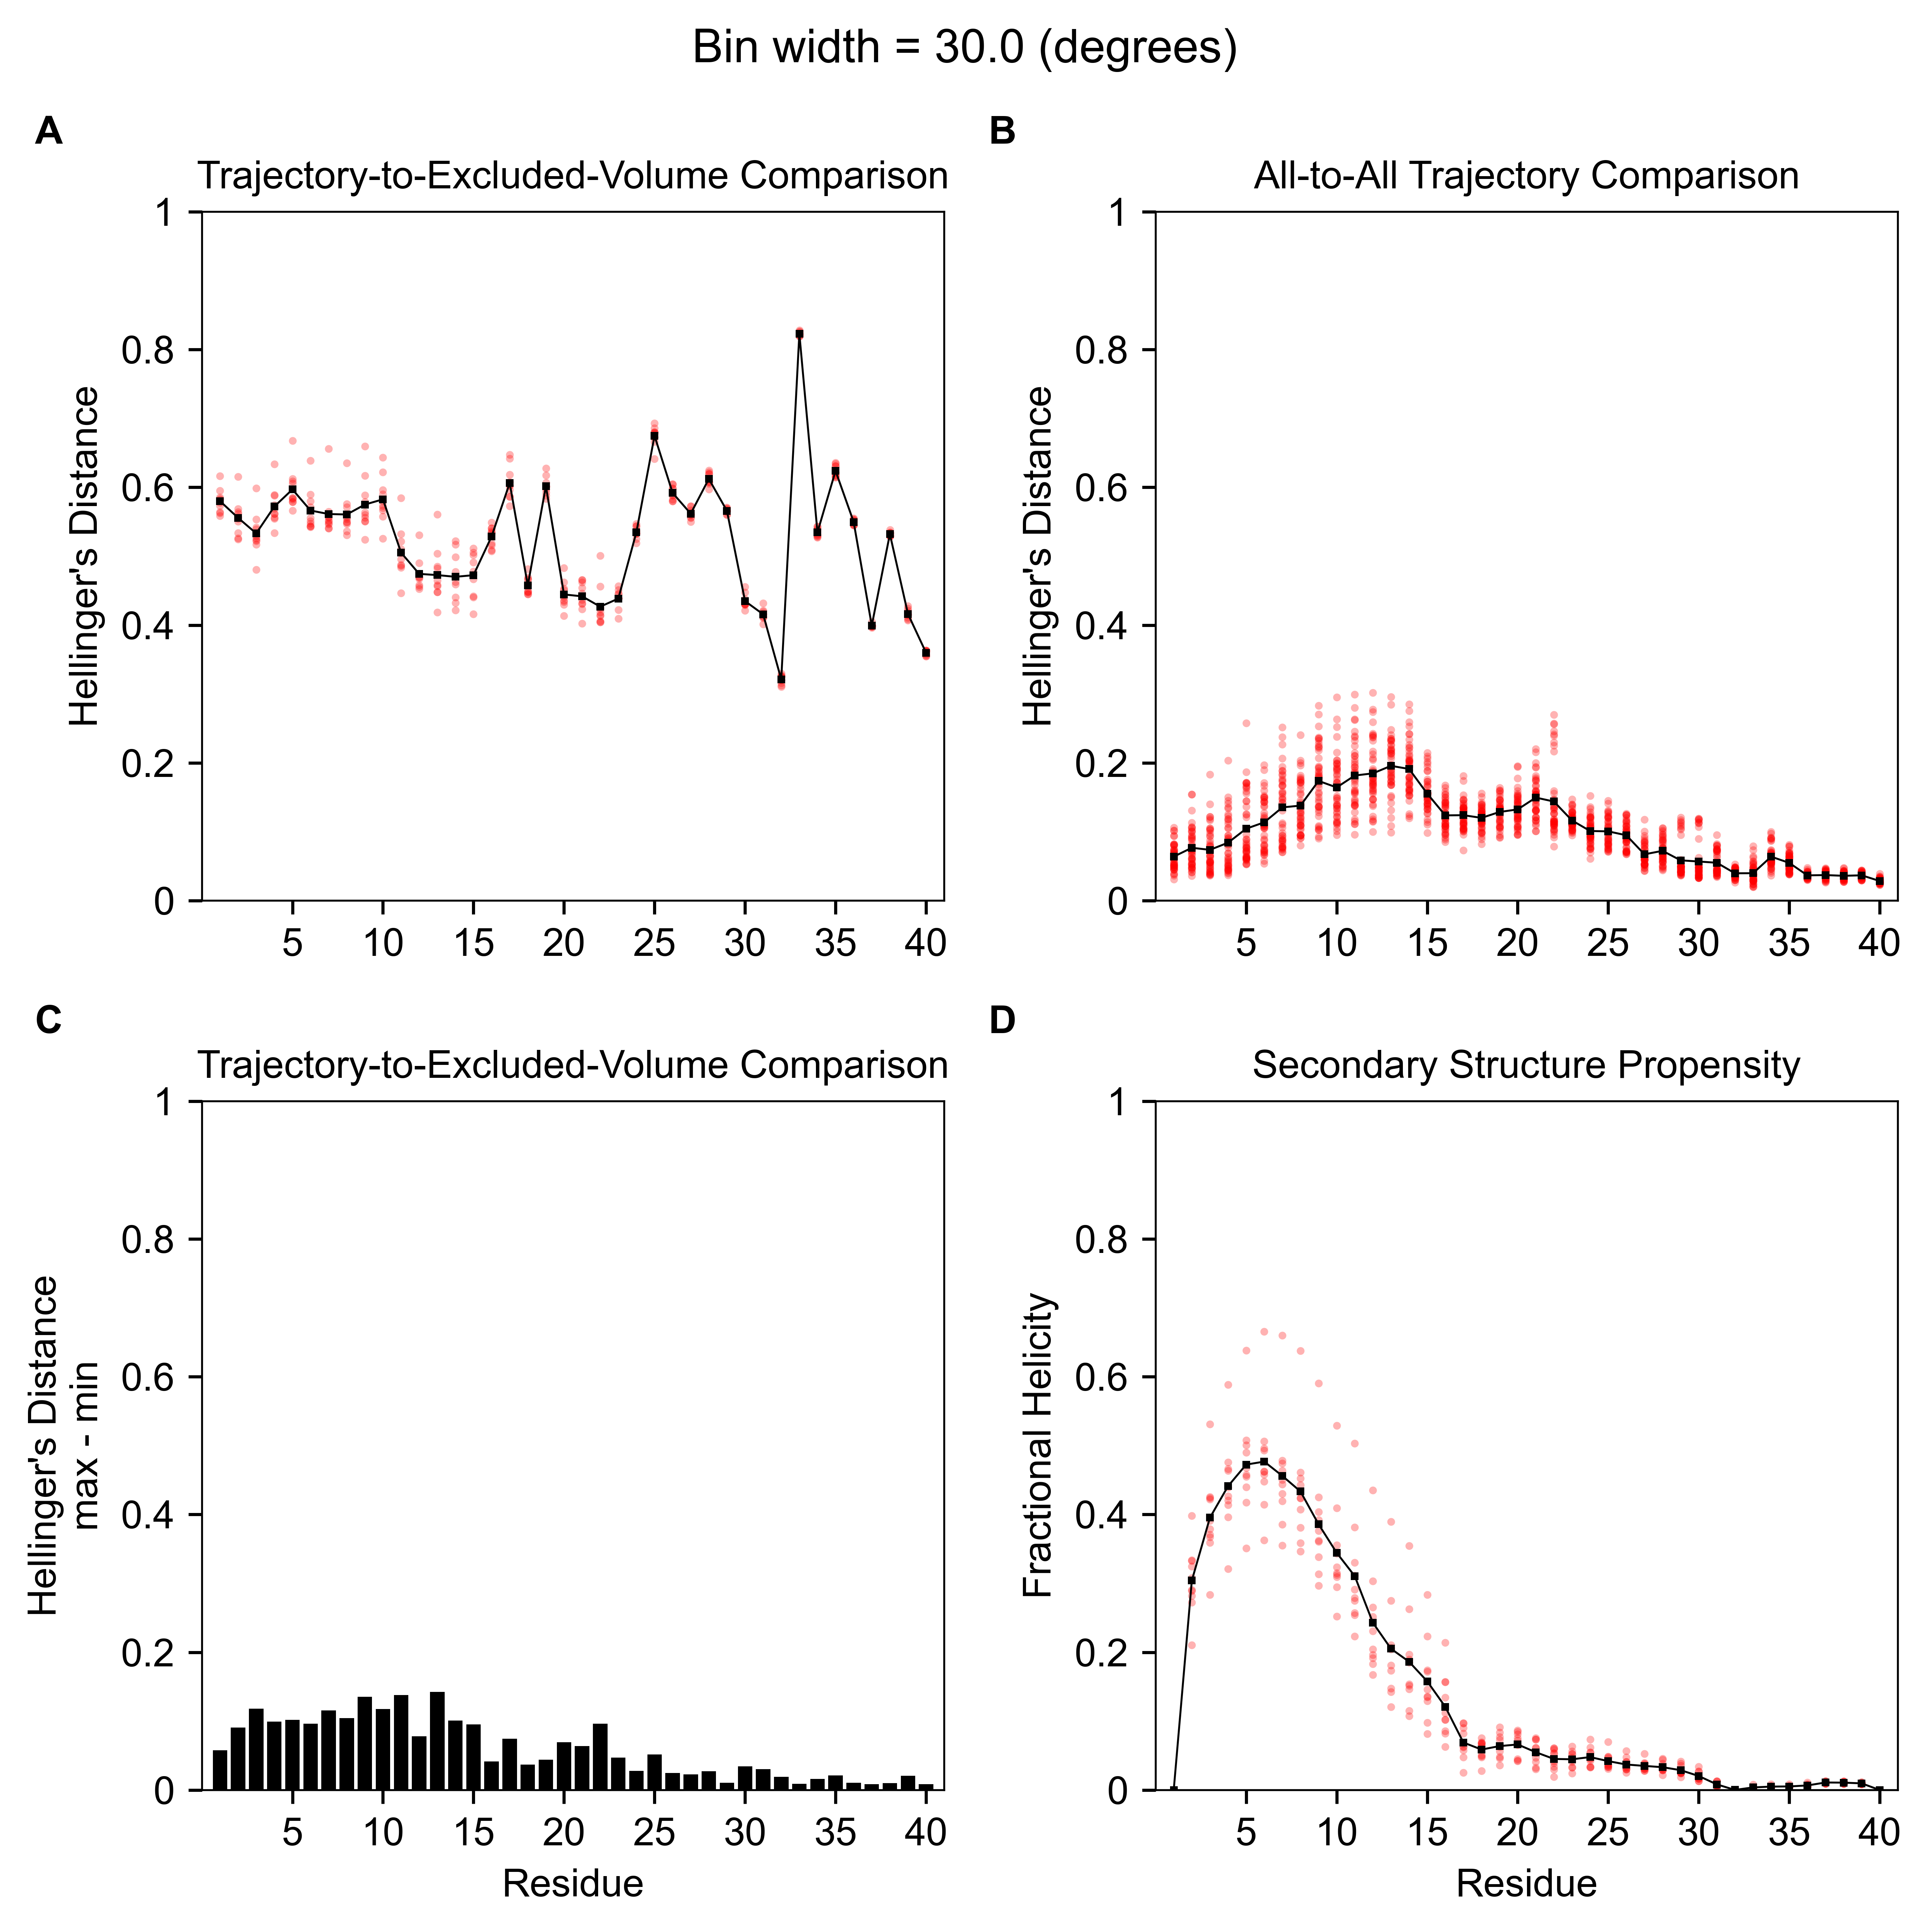

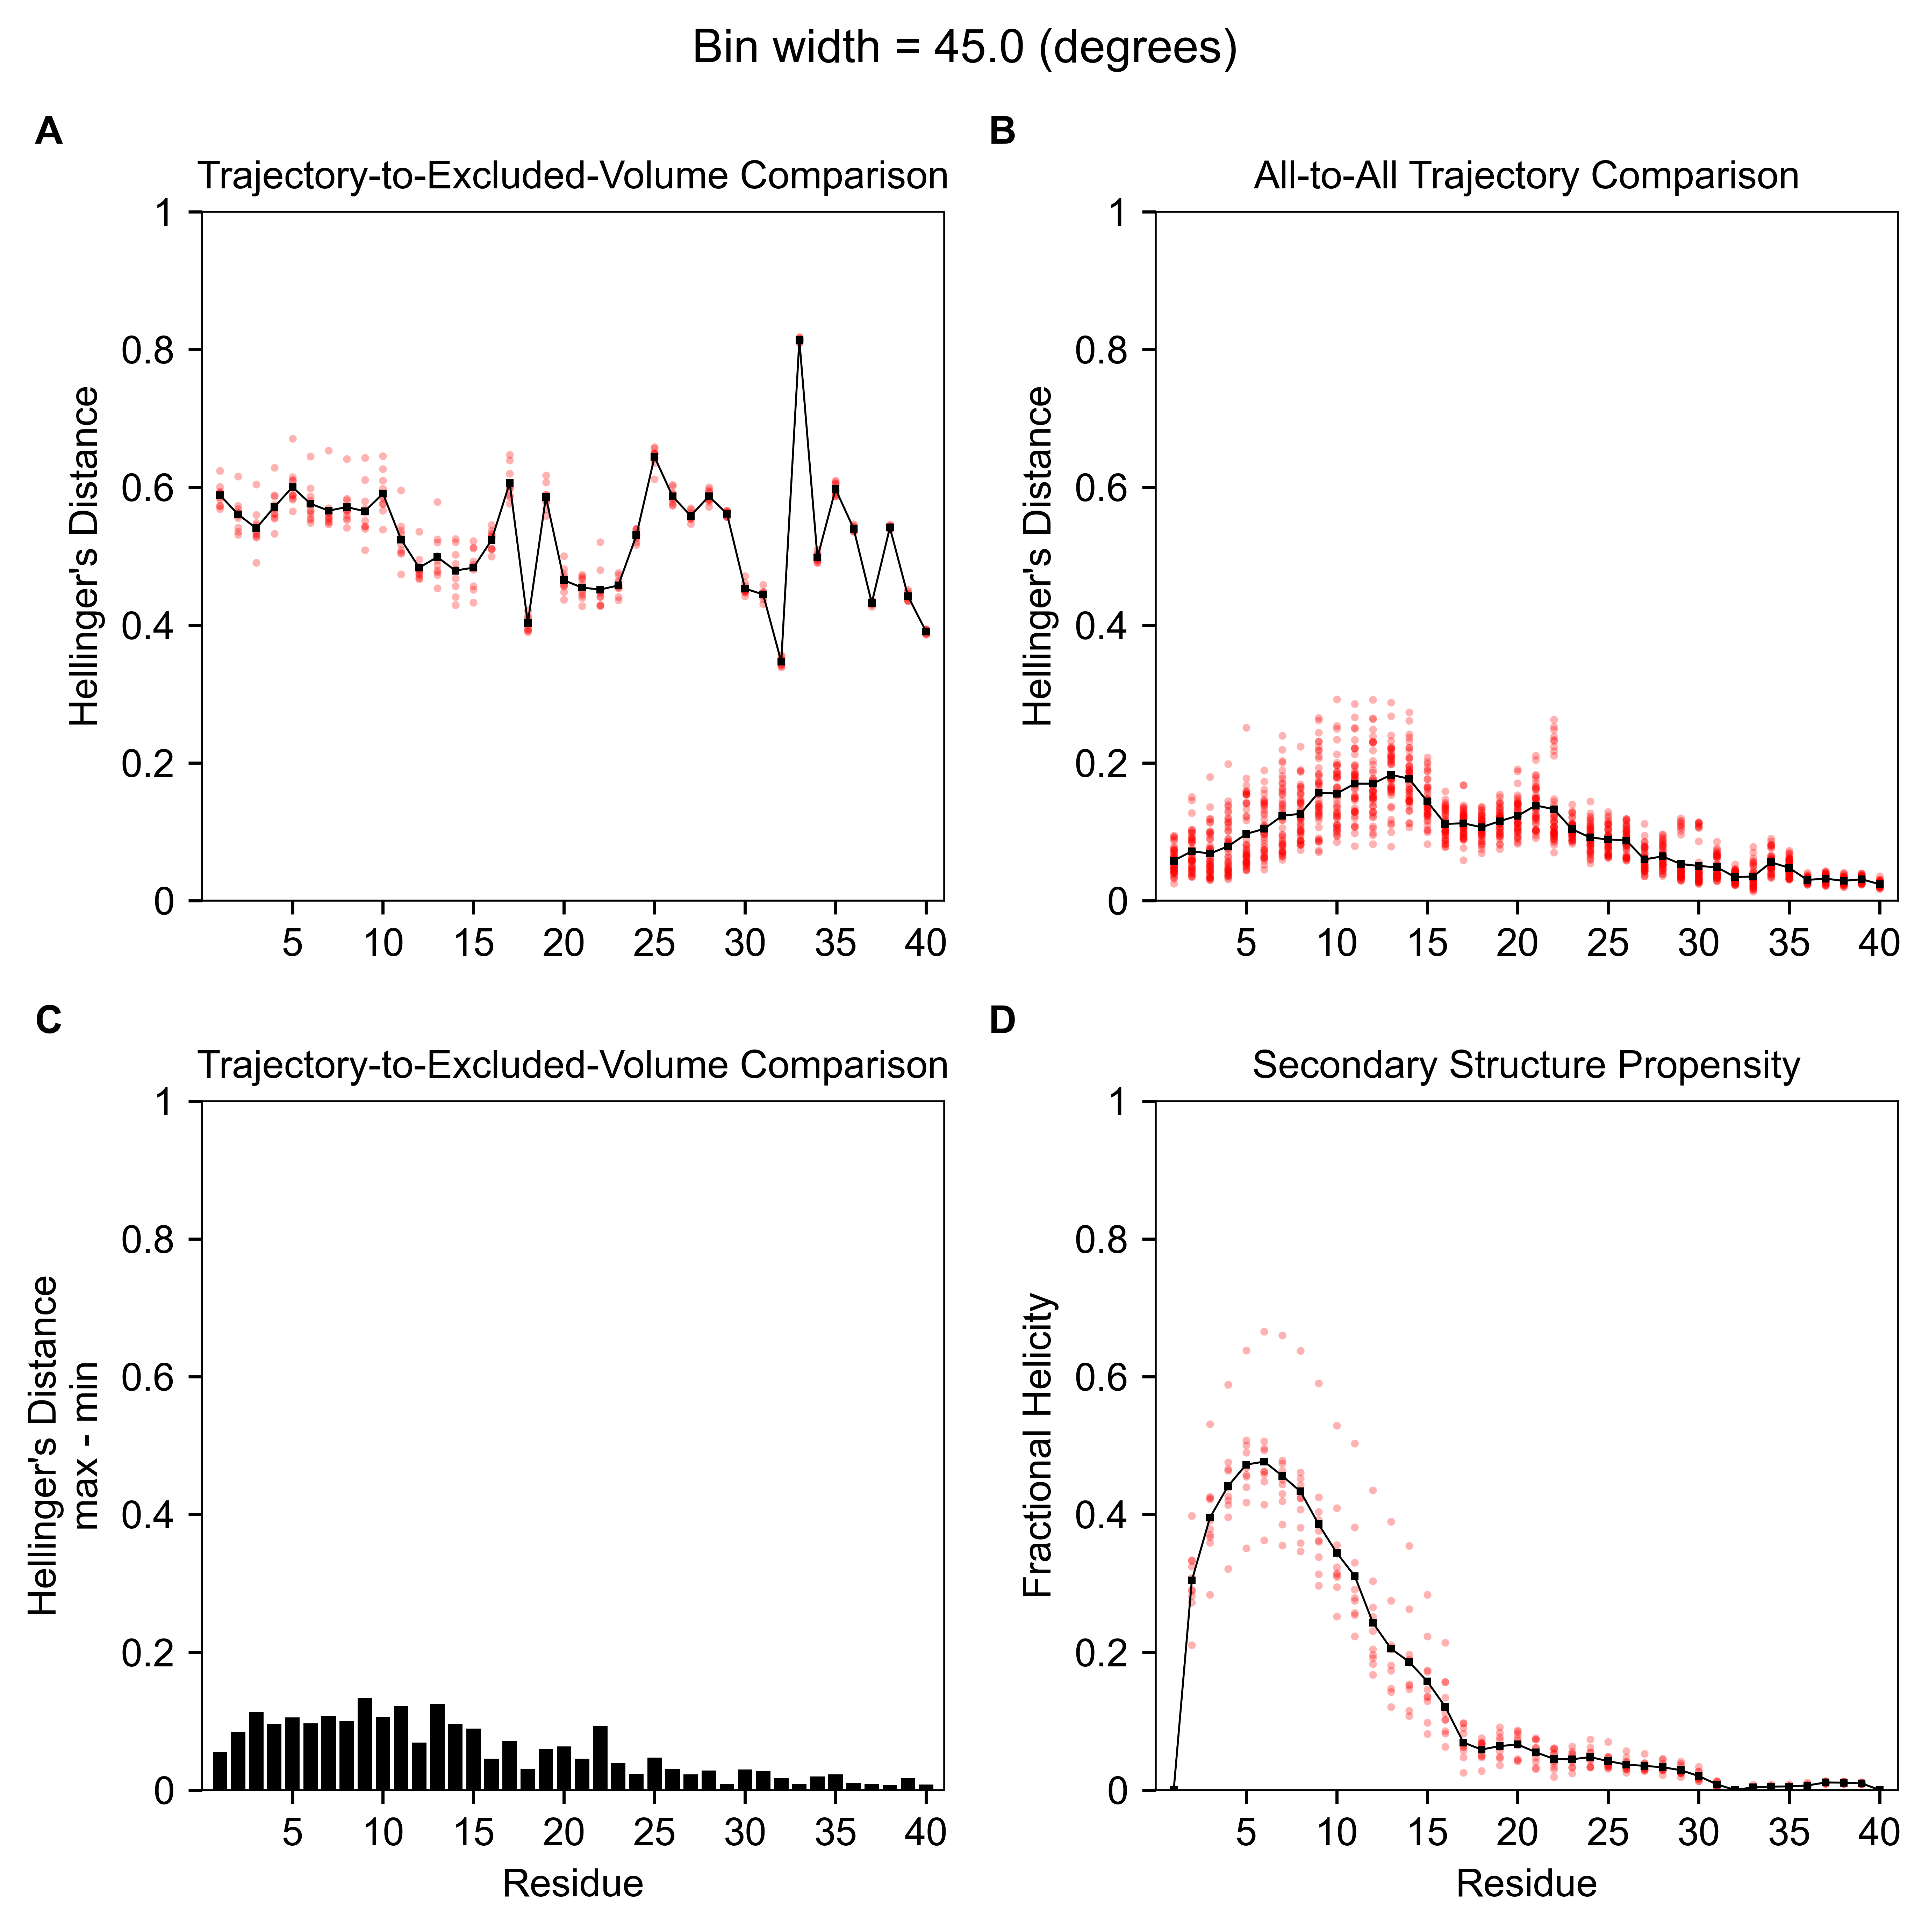

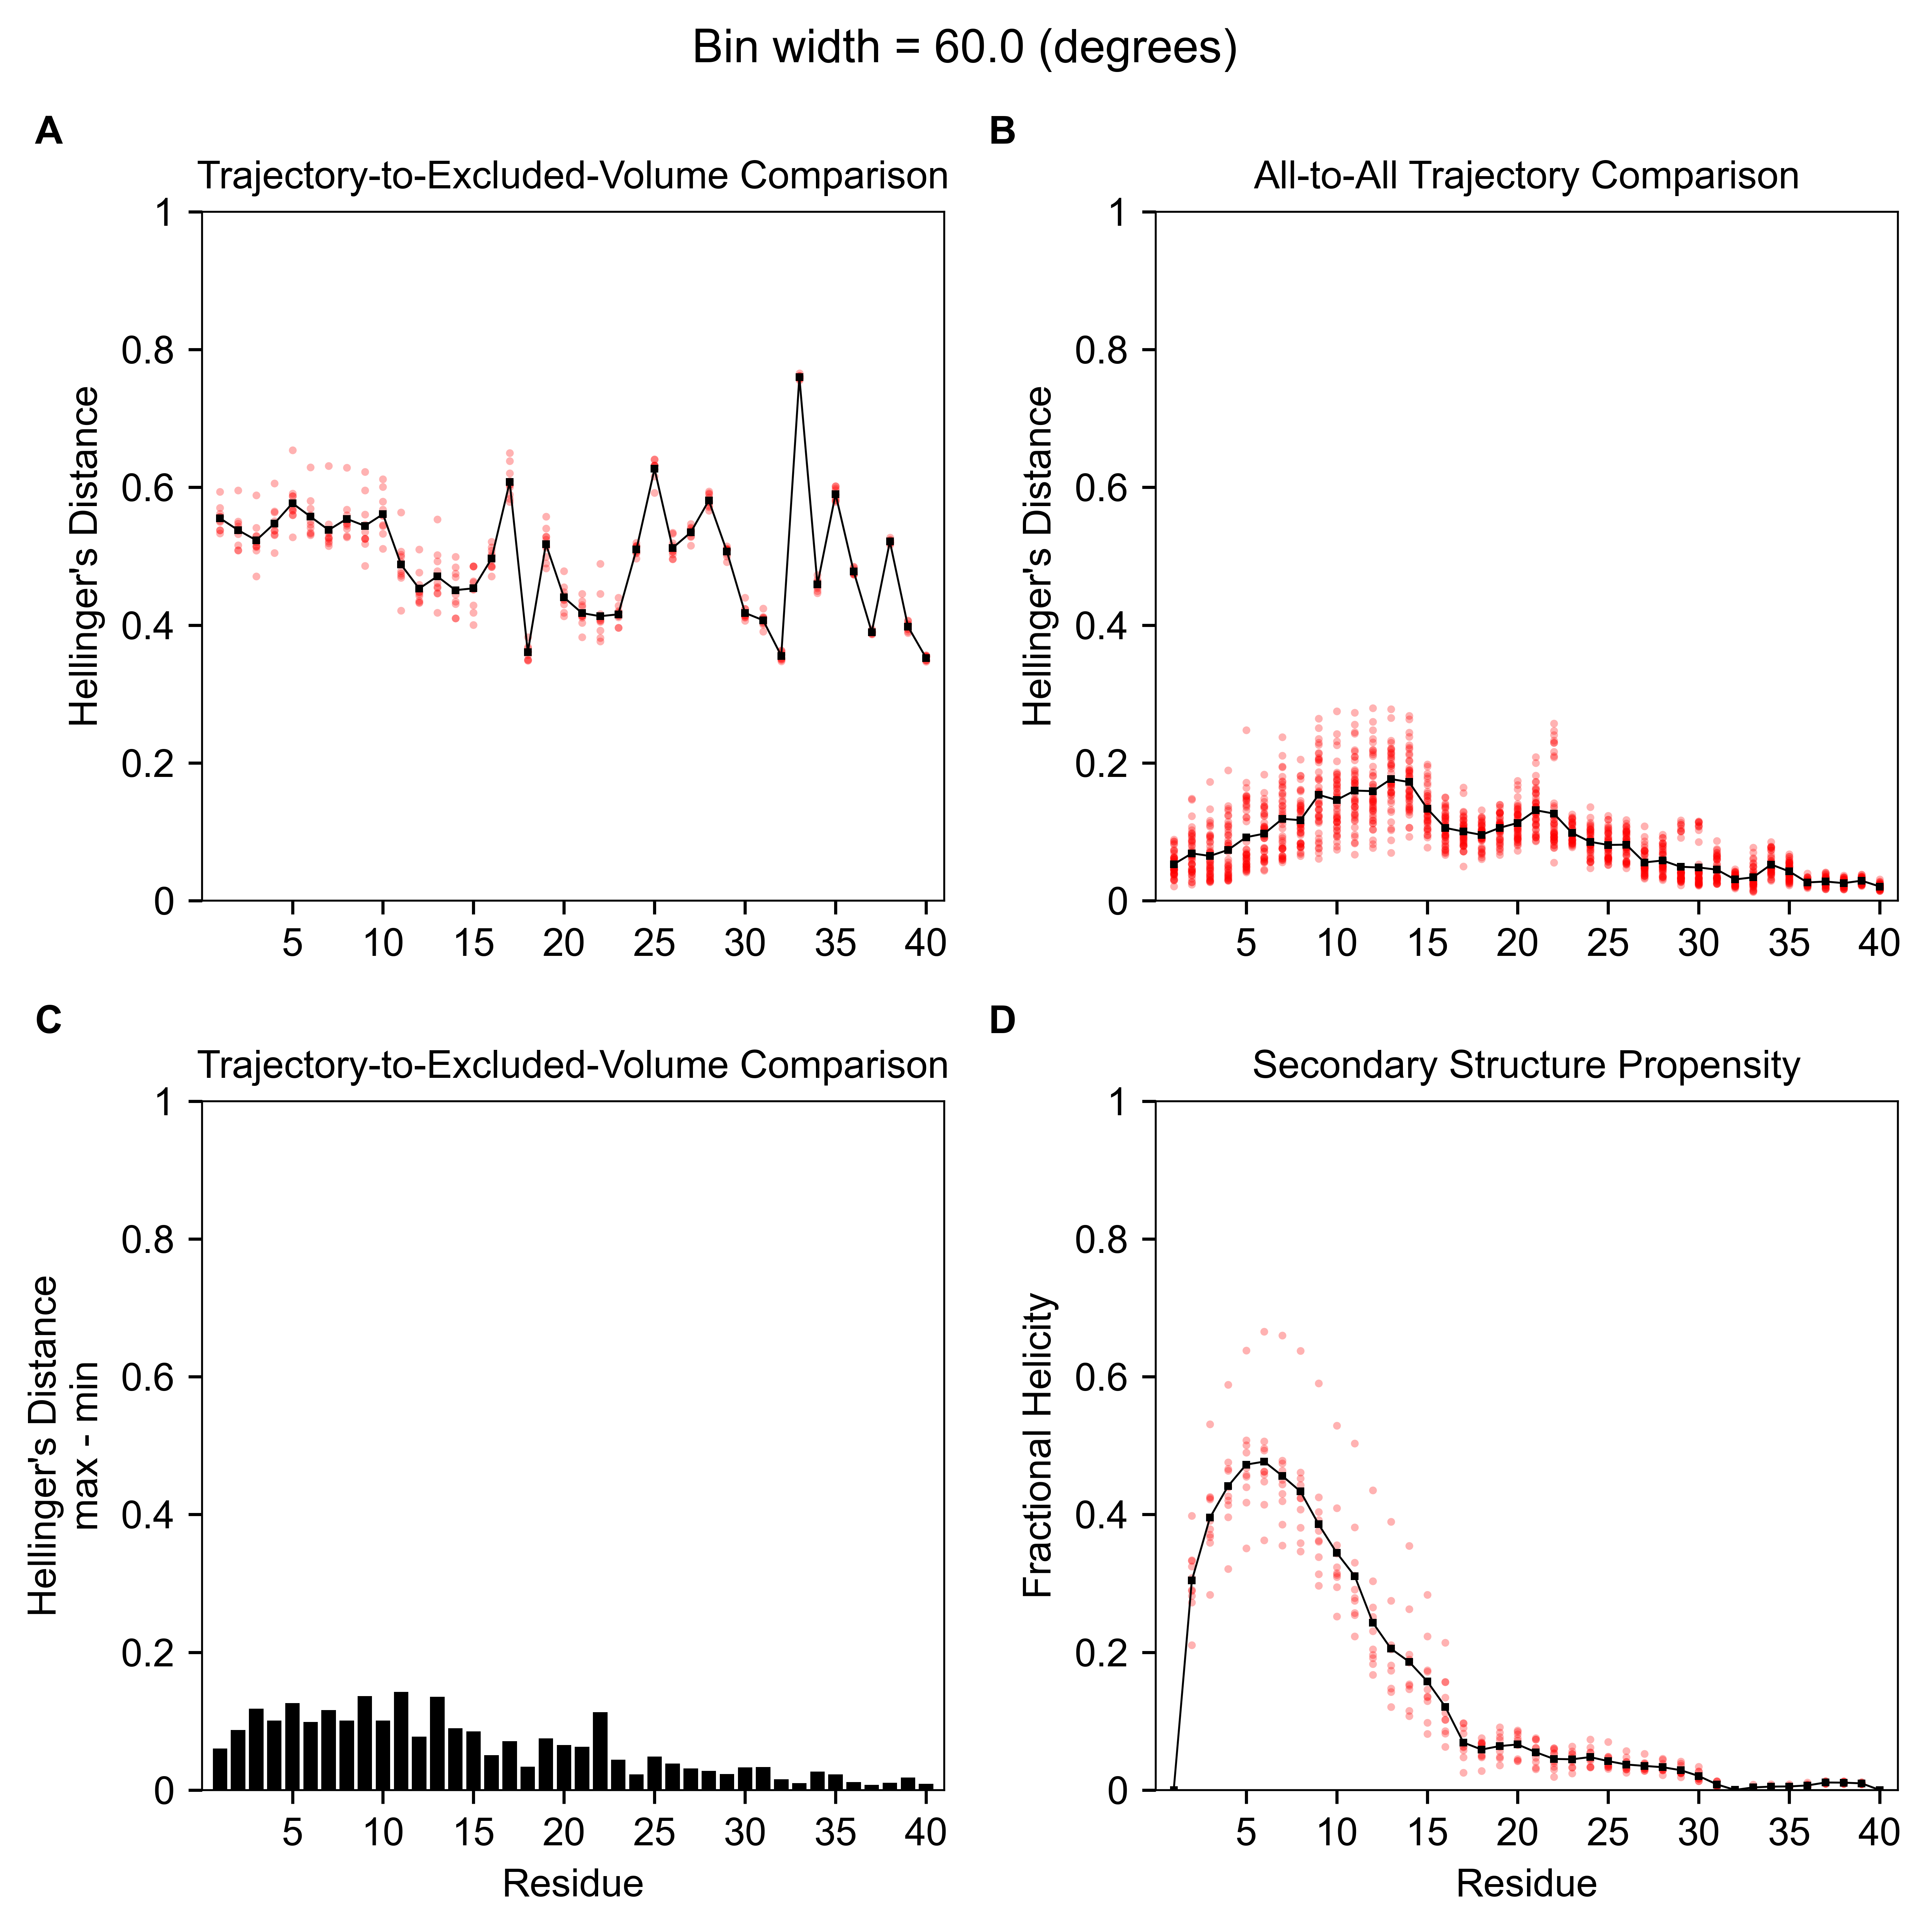

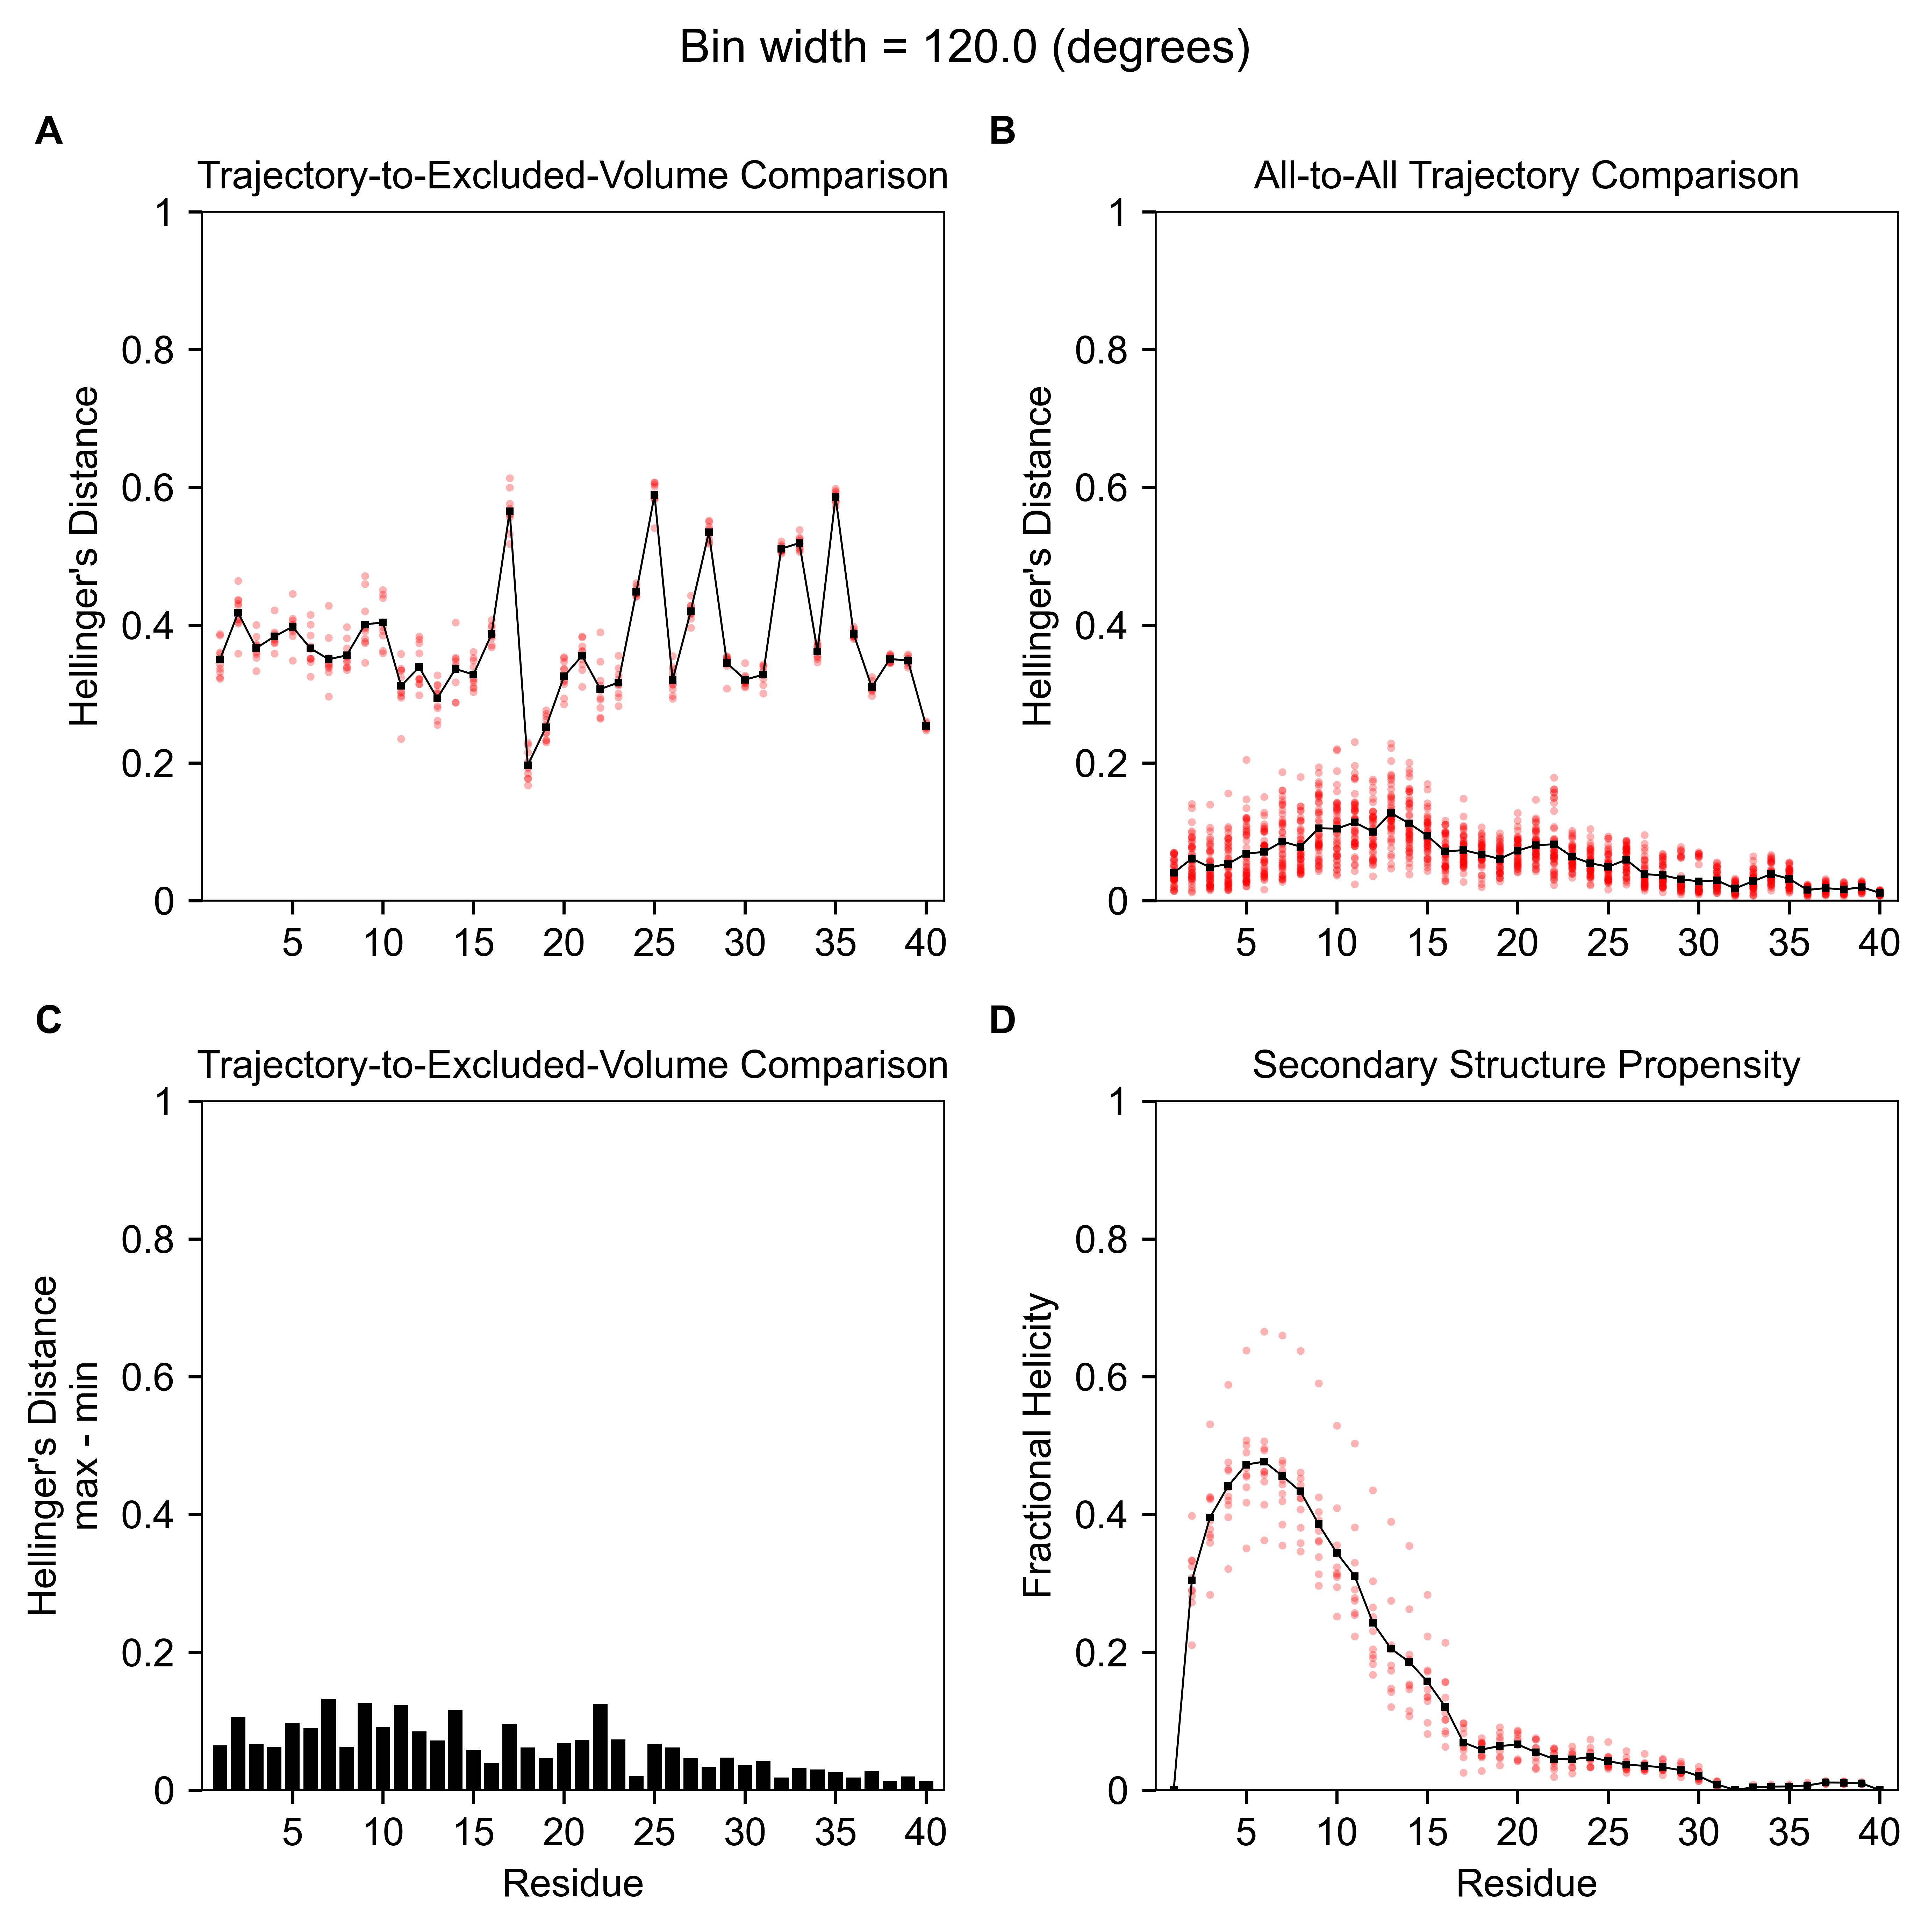

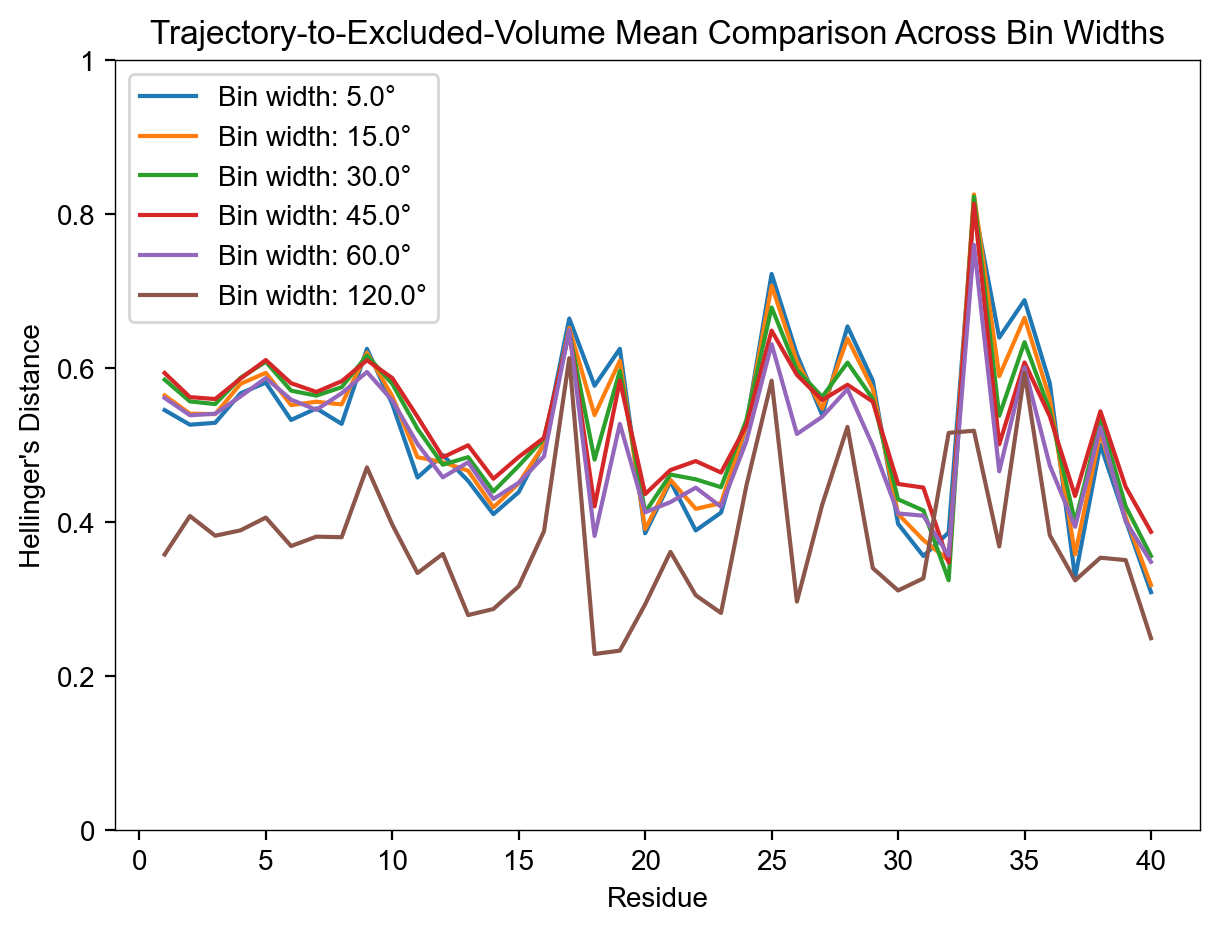

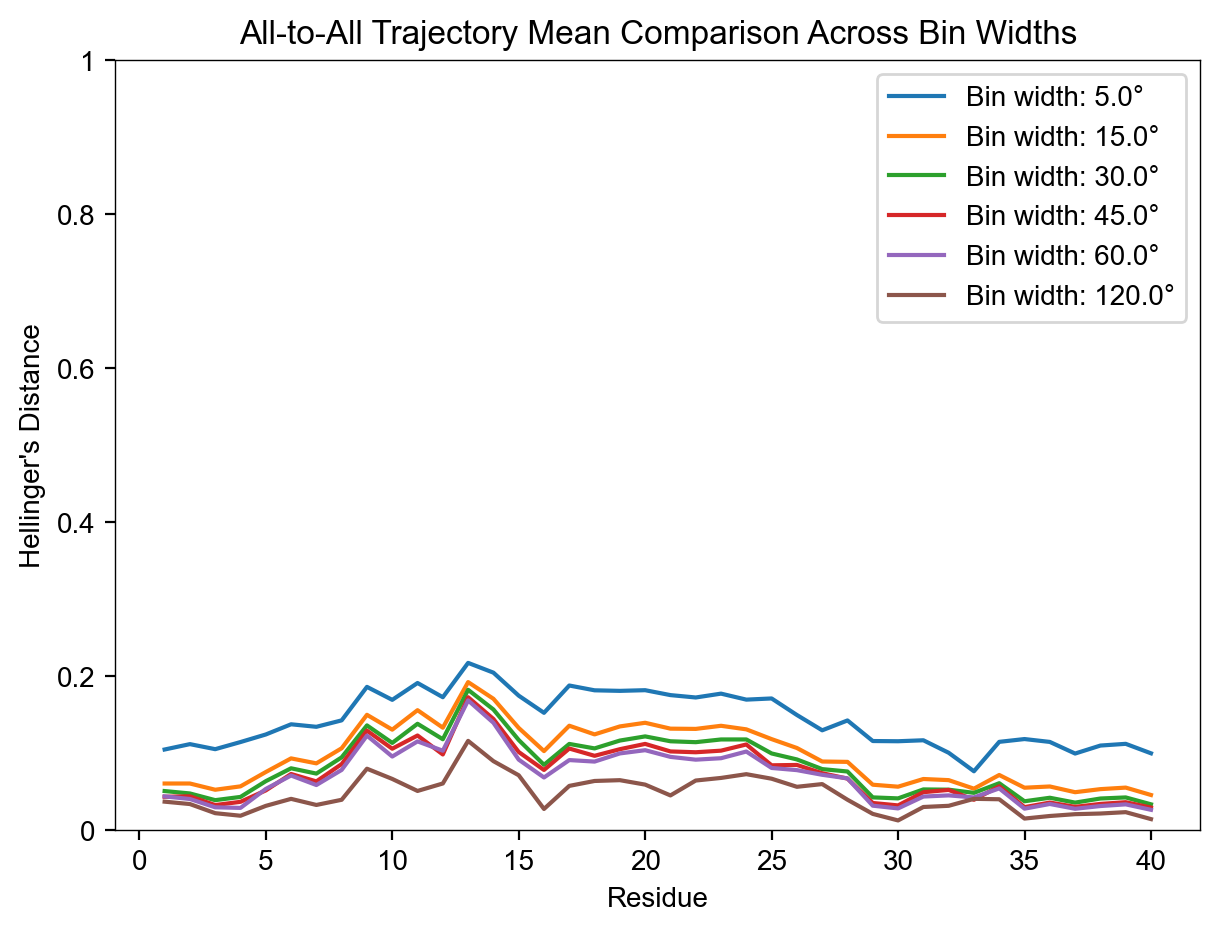

In [10]:
def compare_axes_across_bin_widths(bin_widths,fig_path,workdir,system=None,precomputed=False):
    """
    Generate comparison plots for the first and second axes (`ax[0]` and `ax[1]`)
    across multiple bin widths.

    Parameters:
        quality_plot_func: The function to generate individual subplots.
        qual: The quality object containing the data for plotting.
        bin_widths: List of bin widths to iterate over.
        kwargs: Additional keyword arguments to pass to the quality_plot_func.

    Returns:
        fig1, fig2: Figures for the comparisons of `ax[0]` and `ax[1]`.
    """
    # Store the data for ax[0] and ax[1] across bin widths
    ax0_data = []
    ax1_data = []
    if not precomputed:
        traj_paths, top_paths = find_trajectory_files(workdir, num_replicates=10)
        ev_traj_paths, ev_top_paths = find_trajectory_files(workdir, num_replicates=10)
    else:
        traj_paths, top_paths = find_trajectory_files(workdir, num_replicates=10)
        
    for bwidth in tqdm(bin_widths):
        # Generate the plots and get the axes
        qual = SamplingQuality(traj_paths,
                                top_file=top_paths[0],
                                method="2D angle distributions",
                                bwidth=np.deg2rad(bwidth)
            )
        
        fig, axd = quality_plot_with_annotations(
            qual,
            figsize=(7, 7),
            increment=5,
            panel_labels="""AABB;CCDD""",
            fontsize=10,
            dihedral="2D",
            system=system,
            save_dir=f"{fig_path}/si_figures/pdfs",
            figname=f"{round(np.rad2deg(qual.bwidth), 2)}",
            title=True
        )
        # Extract data for ax[0] and ax[1]
        ax0_lines = axd['A'].lines  # Assuming axd['A'] corresponds to ax[0]
        ax1_lines = axd['B'].lines  # Assuming axd['B'] corresponds to ax[1]

        # Extract the mean line data (assuming it's the second line)
        ax0_data.append(ax0_lines[1].get_ydata())
        ax1_data.append(ax1_lines[1].get_ydata())

        # plt.close(fig)  # Close the individual plot to save memory

    # Prepare residue indices
    residues = np.arange(1, len(ax0_data[0]) + 1)

    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ytick_labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    
    
    # Create comparison plots
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    for i, data in enumerate(ax0_data):
        ax1.plot(residues, data, label=f'Bin width: {bin_widths[i]:.1f}°')
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ytick_labels, fontsize=10)
    ax1.set_ylim([0, 1])
    ax1.set_title("Trajectory-to-Excluded-Volume Mean Comparison Across Bin Widths")
    ax1.set_xlabel("Residue")
    ax1.set_ylabel("Hellinger's Distance")
    plt.savefig(f"{fig_path}/si_figures/pdfs/{system}_traj_to_excluded_volume_mean_bin_width_comparison.pdf",dpi=300)
    ax1.legend()

    fig2, ax2 = plt.subplots(figsize=(7, 5))
    for i, data in enumerate(ax1_data):
        ax2.plot(residues, data, label=f'Bin width: {bin_widths[i]:.1f}°')
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(ytick_labels, fontsize=10)
    ax2.set_ylim([0, 1])
    ax2.set_title("All-to-All Trajectory Mean Comparison Across Bin Widths")
    ax2.set_xlabel("Residue")
    ax2.set_ylabel("Hellinger's Distance")
    plt.savefig(f"{fig_path}/si_figures/pdfs/{system}_all_to_all_traj_mean_bin_width_comparison.pdf",dpi=300)
    ax2.legend()

    return fig1, fig2


# Define bin widths and the figure save path
bin_widths = [5, 15, 30, 45, 60, 120]

# Call the function
compare_axes_across_bin_widths(bin_widths, fig_path, synth_workdir,system="synth", precomputed=True)

# ASH1 DESRES

In [6]:
ash1_md = SSTrajectory("simulations/desres-ash1/full.xtc","simulations/desres-ash1/full.pdb")

In [15]:
# Total number of frames in the trajectory
total_frames = len(ash1_md)
segments = 5
frames_per_segment = total_frames // segments

# Ensure the output directories exist
for i in range(1, segments + 1):
    os.makedirs(f"simulations/ash1_desres/{i}", exist_ok=True)

# Split and save each segment
for i in range(segments):
    start_frame = i * frames_per_segment
    end_frame = (i + 1) * frames_per_segment if i < segments - 1 else total_frames
    segment = ash1_md.traj[start_frame:end_frame]
    output_path = f"simulations/ash1_desres/{i + 1}/__traj.xtc"
    
    # Save the trajectory segment
    segment.save(output_path)
    print(f"Saved segment {i + 1} to {output_path}")

Saved segment 1 to simulations/ash1_desres/1/__traj.xtc
Saved segment 2 to simulations/ash1_desres/2/__traj.xtc
Saved segment 3 to simulations/ash1_desres/3/__traj.xtc
Saved segment 4 to simulations/ash1_desres/4/__traj.xtc
Saved segment 5 to simulations/ash1_desres/5/__traj.xtc


In [22]:
ash1_md_traj_paths, ash1_md_top_paths,  = find_trajectory_files("simulations/ash1_desres/",5,top_name="full.pdb")
ash1_ev_traj_paths, ash1_ev_top_paths,  = find_trajectory_files("simulations/ash1_mc/ev",5,)


In [60]:
phi = ash1_md.proteinTrajectoryList[0].get_angles("phi")[1]
psi = ash1_md.proteinTrajectoryList[0].get_angles("psi")[1]


In [23]:
ash1_md_qual = SamplingQuality(ash1_md_traj_paths,
                               top_file=ash1_md_top_paths[0],
                               method="2D angle distributions",
                               )


AABB;CCDD
(3, 82)


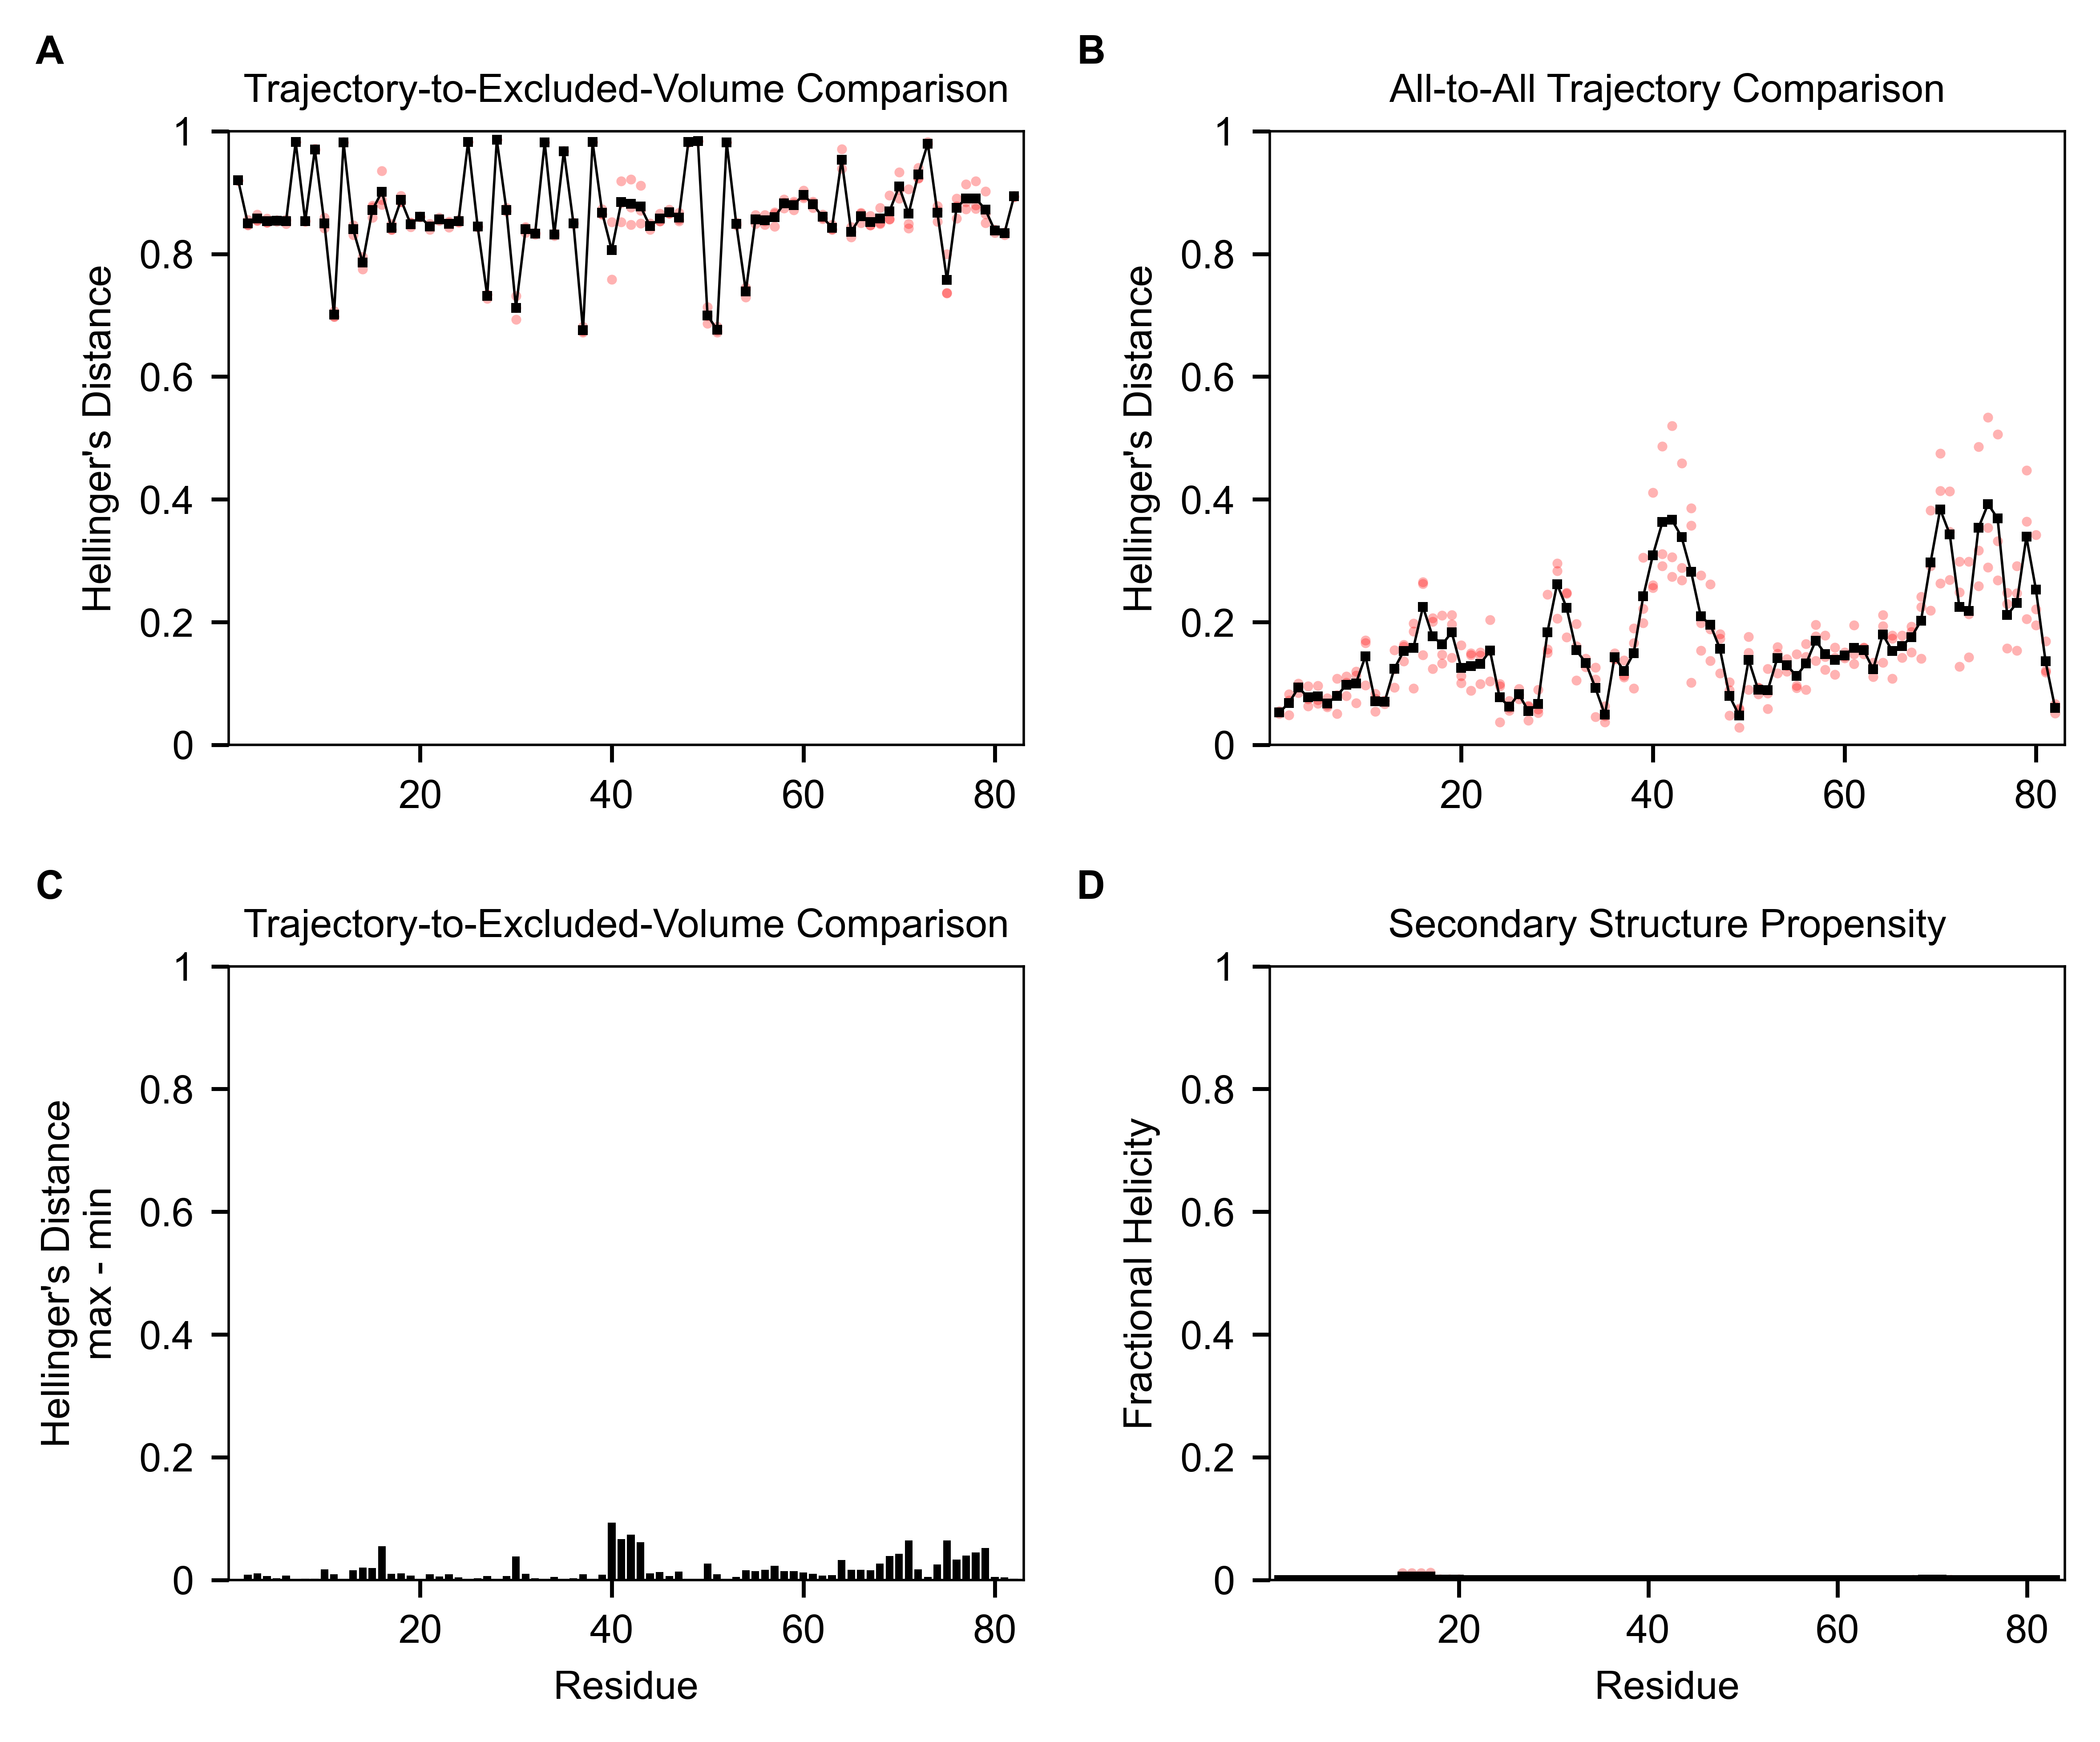

In [24]:
fig,ax = quality_plot_with_annotations(ash1_md_qual,
                        panel_labels="""AABB;CCDD""",
                        figsize=(6,5),
                        increment=20,
                        fontsize=8,
                        dihedral="2D",
                        label_position=(-0.1,1.15),
                        save_dir=f"{fig_path}/si_figures/SI_ash1_md/",
                        system="ash1_md_3replicas",
                        )
